In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(365424, 828)
(365424, 8)
validation
(56968, 828)
(56968, 8)
test
(29712, 828)
(29712, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 46s - loss: 2.9392 - STD: 0.0870 - MAE: 0.2294

 4/37 [==>...........................] - ETA: 1s - loss: 2.2094 - STD: 0.0679 - MAE: 0.2146 

 5/37 [===>..........................] - ETA: 1s - loss: 2.0617 - STD: 0.0802 - MAE: 0.2061

 6/37 [===>..........................] - ETA: 1s - loss: 1.9590 - STD: 0.0964 - MAE: 0.1977

 7/37 [====>.........................] - ETA: 1s - loss: 1.8847 - STD: 0.1126 - MAE: 0.1900

 8/37 [=====>........................] - ETA: 1s - loss: 1.8318 - STD: 0.1272 - MAE: 0.1833

 9/37 [======>.......................] - ETA: 1s - loss: 1.7902 - STD: 0.1398 - MAE: 0.1776

10/37 [=======>......................] - ETA: 1s - loss: 1.7613 - STD: 0.1502 - MAE: 0.1731

11/37 [=======>......................] - ETA: 1s - loss: 1.7364 - STD: 0.1587 - MAE: 0.1695

12/37 [========>.....................] - ETA: 1s - loss: 1.7129 - STD: 0.1653 - MAE: 0.1664

13/37 [=========>....................] - ETA: 1s - loss: 1.6902 - STD: 0.1704 - MAE: 0.1640

14/37 [==========>...................] - ETA: 1s - loss: 1.6700 - STD: 0.1739 - MAE: 0.1622

15/37 [===========>..................] - ETA: 1s - loss: 1.6526 - STD: 0.1763 - MAE: 0.1610

16/37 [===========>..................] - ETA: 1s - loss: 1.6362 - STD: 0.1776 - MAE: 0.1602

17/37 [============>.................] - ETA: 1s - loss: 1.6219 - STD: 0.1780 - MAE: 0.1597

18/37 [=============>................] - ETA: 1s - loss: 1.6099 - STD: 0.1779 - MAE: 0.1595

19/37 [==============>...............] - ETA: 1s - loss: 1.5996 - STD: 0.1774 - MAE: 0.1595

20/37 [===============>..............] - ETA: 0s - loss: 1.5899 - STD: 0.1766 - MAE: 0.1596

21/37 [================>.............] - ETA: 0s - loss: 1.5809 - STD: 0.1758 - MAE: 0.1597

22/37 [================>.............] - ETA: 0s - loss: 1.5739 - STD: 0.1749 - MAE: 0.1598

23/37 [=================>............] - ETA: 0s - loss: 1.5658 - STD: 0.1742 - MAE: 0.1599

24/37 [==================>...........] - ETA: 0s - loss: 1.5585 - STD: 0.1737 - MAE: 0.1599

25/37 [===================>..........] - ETA: 0s - loss: 1.5521 - STD: 0.1734 - MAE: 0.1599

26/37 [====================>.........] - ETA: 0s - loss: 1.5457 - STD: 0.1733 - MAE: 0.1598

27/37 [====================>.........] - ETA: 0s - loss: 1.5392 - STD: 0.1734 - MAE: 0.1596

28/37 [=====================>........] - ETA: 0s - loss: 1.5343 - STD: 0.1738 - MAE: 0.1593

29/37 [======================>.......] - ETA: 0s - loss: 1.5285 - STD: 0.1742 - MAE: 0.1590

30/37 [=======================>......] - ETA: 0s - loss: 1.5257 - STD: 0.1748 - MAE: 0.1587

33/37 [=========================>....] - ETA: 0s - loss: 1.5135 - STD: 0.1769 - MAE: 0.1577

34/37 [==========================>...] - ETA: 0s - loss: 1.5104 - STD: 0.1776 - MAE: 0.1574

35/37 [===========================>..] - ETA: 0s - loss: 1.5068 - STD: 0.1782 - MAE: 0.1571

36/37 [============================>.] - ETA: 0s - loss: 1.5029 - STD: 0.1787 - MAE: 0.1568

37/37 [==============================] - ETA: 0s - loss: 1.4989 - STD: 0.1791 - MAE: 0.1565

37/37 [==============================] - 5s 93ms/step - loss: 1.4989 - STD: 0.1791 - MAE: 0.1565 - val_loss: 1.4232 - val_STD: 0.1908 - val_MAE: 0.1530


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3852 - STD: 0.1908 - MAE: 0.1496

 2/37 [>.............................] - ETA: 2s - loss: 1.3748 - STD: 0.1892 - MAE: 0.1498

 3/37 [=>............................] - ETA: 2s - loss: 1.3811 - STD: 0.1876 - MAE: 0.1508

 4/37 [==>...........................] - ETA: 2s - loss: 1.3823 - STD: 0.1860 - MAE: 0.1515

 5/37 [===>..........................] - ETA: 2s - loss: 1.3790 - STD: 0.1845 - MAE: 0.1519

 7/37 [====>.........................] - ETA: 1s - loss: 1.3781 - STD: 0.1818 - MAE: 0.1529

 8/37 [=====>........................] - ETA: 1s - loss: 1.3762 - STD: 0.1808 - MAE: 0.1532

 9/37 [======>.......................] - ETA: 1s - loss: 1.3765 - STD: 0.1800 - MAE: 0.1535

10/37 [=======>......................] - ETA: 1s - loss: 1.3760 - STD: 0.1794 - MAE: 0.1537

11/37 [=======>......................] - ETA: 1s - loss: 1.3758 - STD: 0.1790 - MAE: 0.1539

12/37 [========>.....................] - ETA: 1s - loss: 1.3765 - STD: 0.1788 - MAE: 0.1540

13/37 [=========>....................] - ETA: 1s - loss: 1.3772 - STD: 0.1788 - MAE: 0.1541

14/37 [==========>...................] - ETA: 1s - loss: 1.3771 - STD: 0.1788 - MAE: 0.1541

15/37 [===========>..................] - ETA: 1s - loss: 1.3783 - STD: 0.1789 - MAE: 0.1541

16/37 [===========>..................] - ETA: 1s - loss: 1.3782 - STD: 0.1791 - MAE: 0.1540

17/37 [============>.................] - ETA: 1s - loss: 1.3788 - STD: 0.1794 - MAE: 0.1539

18/37 [=============>................] - ETA: 1s - loss: 1.3779 - STD: 0.1796 - MAE: 0.1538

19/37 [==============>...............] - ETA: 1s - loss: 1.3763 - STD: 0.1799 - MAE: 0.1536

20/37 [===============>..............] - ETA: 1s - loss: 1.3764 - STD: 0.1802 - MAE: 0.1535

21/37 [================>.............] - ETA: 1s - loss: 1.3757 - STD: 0.1804 - MAE: 0.1534

22/37 [================>.............] - ETA: 0s - loss: 1.3756 - STD: 0.1806 - MAE: 0.1533

23/37 [=================>............] - ETA: 0s - loss: 1.3759 - STD: 0.1808 - MAE: 0.1533

24/37 [==================>...........] - ETA: 0s - loss: 1.3765 - STD: 0.1810 - MAE: 0.1532

25/37 [===================>..........] - ETA: 0s - loss: 1.3761 - STD: 0.1810 - MAE: 0.1532

26/37 [====================>.........] - ETA: 0s - loss: 1.3772 - STD: 0.1811 - MAE: 0.1532

27/37 [====================>.........] - ETA: 0s - loss: 1.3771 - STD: 0.1811 - MAE: 0.1532

28/37 [=====================>........] - ETA: 0s - loss: 1.3770 - STD: 0.1810 - MAE: 0.1533

29/37 [======================>.......] - ETA: 0s - loss: 1.3769 - STD: 0.1809 - MAE: 0.1533

30/37 [=======================>......] - ETA: 0s - loss: 1.3770 - STD: 0.1808 - MAE: 0.1533

31/37 [========================>.....] - ETA: 0s - loss: 1.3772 - STD: 0.1807 - MAE: 0.1534

32/37 [========================>.....] - ETA: 0s - loss: 1.3774 - STD: 0.1806 - MAE: 0.1534

33/37 [=========================>....] - ETA: 0s - loss: 1.3779 - STD: 0.1804 - MAE: 0.1535

34/37 [==========================>...] - ETA: 0s - loss: 1.3777 - STD: 0.1803 - MAE: 0.1535

35/37 [===========================>..] - ETA: 0s - loss: 1.3772 - STD: 0.1803 - MAE: 0.1535

36/37 [============================>.] - ETA: 0s - loss: 1.3772 - STD: 0.1802 - MAE: 0.1536

37/37 [==============================] - ETA: 0s - loss: 1.3771 - STD: 0.1802 - MAE: 0.1536

37/37 [==============================] - 2s 65ms/step - loss: 1.3771 - STD: 0.1802 - MAE: 0.1536 - val_loss: 1.4146 - val_STD: 0.1804 - val_MAE: 0.1565


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3642 - STD: 0.1804 - MAE: 0.1525

 2/37 [>.............................] - ETA: 2s - loss: 1.3692 - STD: 0.1811 - MAE: 0.1528

 3/37 [=>............................] - ETA: 2s - loss: 1.3723 - STD: 0.1816 - MAE: 0.1529

 4/37 [==>...........................] - ETA: 2s - loss: 1.3728 - STD: 0.1820 - MAE: 0.1528

 5/37 [===>..........................] - ETA: 1s - loss: 1.3769 - STD: 0.1823 - MAE: 0.1529

 6/37 [===>..........................] - ETA: 1s - loss: 1.3771 - STD: 0.1825 - MAE: 0.1528

 7/37 [====>.........................] - ETA: 1s - loss: 1.3758 - STD: 0.1825 - MAE: 0.1527

 8/37 [=====>........................] - ETA: 1s - loss: 1.3741 - STD: 0.1825 - MAE: 0.1526

 9/37 [======>.......................] - ETA: 1s - loss: 1.3749 - STD: 0.1825 - MAE: 0.1526

10/37 [=======>......................] - ETA: 1s - loss: 1.3753 - STD: 0.1824 - MAE: 0.1527

11/37 [=======>......................] - ETA: 1s - loss: 1.3751 - STD: 0.1823 - MAE: 0.1527

12/37 [========>.....................] - ETA: 1s - loss: 1.3756 - STD: 0.1822 - MAE: 0.1528

13/37 [=========>....................] - ETA: 1s - loss: 1.3755 - STD: 0.1820 - MAE: 0.1528

14/37 [==========>...................] - ETA: 1s - loss: 1.3767 - STD: 0.1819 - MAE: 0.1529

15/37 [===========>..................] - ETA: 1s - loss: 1.3751 - STD: 0.1817 - MAE: 0.1529

16/37 [===========>..................] - ETA: 1s - loss: 1.3745 - STD: 0.1816 - MAE: 0.1529

17/37 [============>.................] - ETA: 1s - loss: 1.3750 - STD: 0.1815 - MAE: 0.1530

18/37 [=============>................] - ETA: 1s - loss: 1.3750 - STD: 0.1815 - MAE: 0.1530

19/37 [==============>...............] - ETA: 1s - loss: 1.3755 - STD: 0.1814 - MAE: 0.1531

20/37 [===============>..............] - ETA: 1s - loss: 1.3758 - STD: 0.1814 - MAE: 0.1531

21/37 [================>.............] - ETA: 0s - loss: 1.3760 - STD: 0.1814 - MAE: 0.1531

22/37 [================>.............] - ETA: 0s - loss: 1.3762 - STD: 0.1814 - MAE: 0.1531

23/37 [=================>............] - ETA: 0s - loss: 1.3755 - STD: 0.1814 - MAE: 0.1531

24/37 [==================>...........] - ETA: 0s - loss: 1.3754 - STD: 0.1814 - MAE: 0.1530

25/37 [===================>..........] - ETA: 0s - loss: 1.3758 - STD: 0.1814 - MAE: 0.1531

26/37 [====================>.........] - ETA: 0s - loss: 1.3759 - STD: 0.1814 - MAE: 0.1531

27/37 [====================>.........] - ETA: 0s - loss: 1.3760 - STD: 0.1814 - MAE: 0.1531

28/37 [=====================>........] - ETA: 0s - loss: 1.3756 - STD: 0.1814 - MAE: 0.1530

29/37 [======================>.......] - ETA: 0s - loss: 1.3762 - STD: 0.1814 - MAE: 0.1531

30/37 [=======================>......] - ETA: 0s - loss: 1.3762 - STD: 0.1814 - MAE: 0.1531

31/37 [========================>.....] - ETA: 0s - loss: 1.3763 - STD: 0.1814 - MAE: 0.1531

32/37 [========================>.....] - ETA: 0s - loss: 1.3759 - STD: 0.1814 - MAE: 0.1531

33/37 [=========================>....] - ETA: 0s - loss: 1.3754 - STD: 0.1813 - MAE: 0.1531

34/37 [==========================>...] - ETA: 0s - loss: 1.3757 - STD: 0.1813 - MAE: 0.1531

35/37 [===========================>..] - ETA: 0s - loss: 1.3761 - STD: 0.1813 - MAE: 0.1531

36/37 [============================>.] - ETA: 0s - loss: 1.3760 - STD: 0.1812 - MAE: 0.1532

37/37 [==============================] - 2s 66ms/step - loss: 1.3759 - STD: 0.1812 - MAE: 0.1532 - val_loss: 1.4133 - val_STD: 0.1800 - val_MAE: 0.1566


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3749 - STD: 0.1800 - MAE: 0.1535

 2/37 [>.............................] - ETA: 2s - loss: 1.3772 - STD: 0.1802 - MAE: 0.1535

 3/37 [=>............................] - ETA: 2s - loss: 1.3714 - STD: 0.1804 - MAE: 0.1532

 4/37 [==>...........................] - ETA: 2s - loss: 1.3699 - STD: 0.1806 - MAE: 0.1531

 5/37 [===>..........................] - ETA: 2s - loss: 1.3722 - STD: 0.1809 - MAE: 0.1532

 6/37 [===>..........................] - ETA: 2s - loss: 1.3727 - STD: 0.1810 - MAE: 0.1531

 7/37 [====>.........................] - ETA: 1s - loss: 1.3730 - STD: 0.1812 - MAE: 0.1530

 8/37 [=====>........................] - ETA: 1s - loss: 1.3716 - STD: 0.1814 - MAE: 0.1529

 9/37 [======>.......................] - ETA: 1s - loss: 1.3730 - STD: 0.1815 - MAE: 0.1529

10/37 [=======>......................] - ETA: 1s - loss: 1.3733 - STD: 0.1816 - MAE: 0.1529

11/37 [=======>......................] - ETA: 1s - loss: 1.3736 - STD: 0.1816 - MAE: 0.1529

12/37 [========>.....................] - ETA: 1s - loss: 1.3735 - STD: 0.1816 - MAE: 0.1529

14/37 [==========>...................] - ETA: 1s - loss: 1.3734 - STD: 0.1816 - MAE: 0.1529

15/37 [===========>..................] - ETA: 1s - loss: 1.3724 - STD: 0.1815 - MAE: 0.1528

16/37 [===========>..................] - ETA: 1s - loss: 1.3726 - STD: 0.1814 - MAE: 0.1529

17/37 [============>.................] - ETA: 1s - loss: 1.3731 - STD: 0.1814 - MAE: 0.1529

18/37 [=============>................] - ETA: 1s - loss: 1.3728 - STD: 0.1814 - MAE: 0.1529

19/37 [==============>...............] - ETA: 1s - loss: 1.3737 - STD: 0.1813 - MAE: 0.1530

20/37 [===============>..............] - ETA: 1s - loss: 1.3734 - STD: 0.1813 - MAE: 0.1530

21/37 [================>.............] - ETA: 1s - loss: 1.3736 - STD: 0.1812 - MAE: 0.1530

22/37 [================>.............] - ETA: 1s - loss: 1.3742 - STD: 0.1812 - MAE: 0.1531

23/37 [=================>............] - ETA: 0s - loss: 1.3737 - STD: 0.1811 - MAE: 0.1531

24/37 [==================>...........] - ETA: 0s - loss: 1.3735 - STD: 0.1810 - MAE: 0.1531

25/37 [===================>..........] - ETA: 0s - loss: 1.3741 - STD: 0.1810 - MAE: 0.1531

26/37 [====================>.........] - ETA: 0s - loss: 1.3738 - STD: 0.1809 - MAE: 0.1531

27/37 [====================>.........] - ETA: 0s - loss: 1.3736 - STD: 0.1809 - MAE: 0.1531

28/37 [=====================>........] - ETA: 0s - loss: 1.3734 - STD: 0.1809 - MAE: 0.1531

29/37 [======================>.......] - ETA: 0s - loss: 1.3731 - STD: 0.1809 - MAE: 0.1531

30/37 [=======================>......] - ETA: 0s - loss: 1.3733 - STD: 0.1809 - MAE: 0.1531

31/37 [========================>.....] - ETA: 0s - loss: 1.3735 - STD: 0.1809 - MAE: 0.1531

32/37 [========================>.....] - ETA: 0s - loss: 1.3737 - STD: 0.1809 - MAE: 0.1532

33/37 [=========================>....] - ETA: 0s - loss: 1.3740 - STD: 0.1809 - MAE: 0.1532

34/37 [==========================>...] - ETA: 0s - loss: 1.3733 - STD: 0.1808 - MAE: 0.1532

35/37 [===========================>..] - ETA: 0s - loss: 1.3724 - STD: 0.1808 - MAE: 0.1531

36/37 [============================>.] - ETA: 0s - loss: 1.3727 - STD: 0.1808 - MAE: 0.1532

37/37 [==============================] - ETA: 0s - loss: 1.3721 - STD: 0.1807 - MAE: 0.1531

37/37 [==============================] - 3s 68ms/step - loss: 1.3721 - STD: 0.1807 - MAE: 0.1531 - val_loss: 1.4000 - val_STD: 0.1800 - val_MAE: 0.1559


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 1.3813 - STD: 0.1802 - MAE: 0.1540

 2/37 [>.............................] - ETA: 2s - loss: 1.3730 - STD: 0.1801 - MAE: 0.1535

 3/37 [=>............................] - ETA: 2s - loss: 1.3783 - STD: 0.1801 - MAE: 0.1538

 4/37 [==>...........................] - ETA: 1s - loss: 1.3730 - STD: 0.1798 - MAE: 0.1536

 5/37 [===>..........................] - ETA: 1s - loss: 1.3739 - STD: 0.1796 - MAE: 0.1538

 6/37 [===>..........................] - ETA: 1s - loss: 1.3726 - STD: 0.1793 - MAE: 0.1538

 7/37 [====>.........................] - ETA: 1s - loss: 1.3672 - STD: 0.1792 - MAE: 0.1535

 8/37 [=====>........................] - ETA: 1s - loss: 1.3663 - STD: 0.1793 - MAE: 0.1534

 9/37 [======>.......................] - ETA: 1s - loss: 1.3653 - STD: 0.1795 - MAE: 0.1533

10/37 [=======>......................] - ETA: 1s - loss: 1.3626 - STD: 0.1798 - MAE: 0.1531

11/37 [=======>......................] - ETA: 1s - loss: 1.3628 - STD: 0.1800 - MAE: 0.1530

12/37 [========>.....................] - ETA: 1s - loss: 1.3629 - STD: 0.1801 - MAE: 0.1529

13/37 [=========>....................] - ETA: 1s - loss: 1.3625 - STD: 0.1802 - MAE: 0.1529

14/37 [==========>...................] - ETA: 1s - loss: 1.3624 - STD: 0.1802 - MAE: 0.1529

15/37 [===========>..................] - ETA: 1s - loss: 1.3608 - STD: 0.1801 - MAE: 0.1528

16/37 [===========>..................] - ETA: 1s - loss: 1.3583 - STD: 0.1802 - MAE: 0.1527

17/37 [============>.................] - ETA: 1s - loss: 1.3562 - STD: 0.1802 - MAE: 0.1526

19/37 [==============>...............] - ETA: 1s - loss: 1.3533 - STD: 0.1805 - MAE: 0.1523

20/37 [===============>..............] - ETA: 1s - loss: 1.3515 - STD: 0.1806 - MAE: 0.1522

21/37 [================>.............] - ETA: 0s - loss: 1.3489 - STD: 0.1806 - MAE: 0.1520

22/37 [================>.............] - ETA: 0s - loss: 1.3475 - STD: 0.1807 - MAE: 0.1519

23/37 [=================>............] - ETA: 0s - loss: 1.3471 - STD: 0.1810 - MAE: 0.1518

24/37 [==================>...........] - ETA: 0s - loss: 1.3451 - STD: 0.1812 - MAE: 0.1517

25/37 [===================>..........] - ETA: 0s - loss: 1.3445 - STD: 0.1814 - MAE: 0.1516

26/37 [====================>.........] - ETA: 0s - loss: 1.3429 - STD: 0.1816 - MAE: 0.1514

27/37 [====================>.........] - ETA: 0s - loss: 1.3416 - STD: 0.1817 - MAE: 0.1514

28/37 [=====================>........] - ETA: 0s - loss: 1.3407 - STD: 0.1817 - MAE: 0.1513

29/37 [======================>.......] - ETA: 0s - loss: 1.3403 - STD: 0.1816 - MAE: 0.1513

30/37 [=======================>......] - ETA: 0s - loss: 1.3394 - STD: 0.1816 - MAE: 0.1513

31/37 [========================>.....] - ETA: 0s - loss: 1.3378 - STD: 0.1818 - MAE: 0.1512

32/37 [========================>.....] - ETA: 0s - loss: 1.3362 - STD: 0.1819 - MAE: 0.1510

33/37 [=========================>....] - ETA: 0s - loss: 1.3347 - STD: 0.1819 - MAE: 0.1510

34/37 [==========================>...] - ETA: 0s - loss: 1.3339 - STD: 0.1819 - MAE: 0.1510

35/37 [===========================>..] - ETA: 0s - loss: 1.3328 - STD: 0.1821 - MAE: 0.1509

36/37 [============================>.] - ETA: 0s - loss: 1.3323 - STD: 0.1823 - MAE: 0.1508

37/37 [==============================] - ETA: 0s - loss: 1.3306 - STD: 0.1825 - MAE: 0.1507

37/37 [==============================] - 2s 64ms/step - loss: 1.3306 - STD: 0.1825 - MAE: 0.1507 - val_loss: 1.3157 - val_STD: 0.1835 - val_MAE: 0.1506


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 1.2998 - STD: 0.1878 - MAE: 0.1480

 2/37 [>.............................] - ETA: 2s - loss: 1.2957 - STD: 0.1878 - MAE: 0.1478

 3/37 [=>............................] - ETA: 1s - loss: 1.2940 - STD: 0.1879 - MAE: 0.1476

 4/37 [==>...........................] - ETA: 1s - loss: 1.2902 - STD: 0.1877 - MAE: 0.1476

 5/37 [===>..........................] - ETA: 1s - loss: 1.2909 - STD: 0.1874 - MAE: 0.1477

 6/37 [===>..........................] - ETA: 2s - loss: 1.2891 - STD: 0.1873 - MAE: 0.1477

 7/37 [====>.........................] - ETA: 2s - loss: 1.2844 - STD: 0.1874 - MAE: 0.1474

 8/37 [=====>........................] - ETA: 2s - loss: 1.2838 - STD: 0.1875 - MAE: 0.1474

 9/37 [======>.......................] - ETA: 1s - loss: 1.2816 - STD: 0.1873 - MAE: 0.1473

10/37 [=======>......................] - ETA: 1s - loss: 1.2780 - STD: 0.1874 - MAE: 0.1471

11/37 [=======>......................] - ETA: 1s - loss: 1.2775 - STD: 0.1880 - MAE: 0.1469

12/37 [========>.....................] - ETA: 1s - loss: 1.2759 - STD: 0.1884 - MAE: 0.1467

14/37 [==========>...................] - ETA: 1s - loss: 1.2746 - STD: 0.1886 - MAE: 0.1466

15/37 [===========>..................] - ETA: 1s - loss: 1.2739 - STD: 0.1890 - MAE: 0.1465

16/37 [===========>..................] - ETA: 1s - loss: 1.2735 - STD: 0.1890 - MAE: 0.1465

17/37 [============>.................] - ETA: 1s - loss: 1.2715 - STD: 0.1890 - MAE: 0.1464

18/37 [=============>................] - ETA: 1s - loss: 1.2710 - STD: 0.1893 - MAE: 0.1463

19/37 [==============>...............] - ETA: 1s - loss: 1.2709 - STD: 0.1894 - MAE: 0.1463

20/37 [===============>..............] - ETA: 1s - loss: 1.2700 - STD: 0.1891 - MAE: 0.1463

21/37 [================>.............] - ETA: 1s - loss: 1.2689 - STD: 0.1893 - MAE: 0.1462

22/37 [================>.............] - ETA: 1s - loss: 1.2666 - STD: 0.1895 - MAE: 0.1460

23/37 [=================>............] - ETA: 0s - loss: 1.2659 - STD: 0.1896 - MAE: 0.1460

24/37 [==================>...........] - ETA: 0s - loss: 1.2654 - STD: 0.1895 - MAE: 0.1460

25/37 [===================>..........] - ETA: 0s - loss: 1.2639 - STD: 0.1898 - MAE: 0.1459

26/37 [====================>.........] - ETA: 0s - loss: 1.2637 - STD: 0.1900 - MAE: 0.1458

27/37 [====================>.........] - ETA: 0s - loss: 1.2631 - STD: 0.1900 - MAE: 0.1458

28/37 [=====================>........] - ETA: 0s - loss: 1.2618 - STD: 0.1900 - MAE: 0.1458

29/37 [======================>.......] - ETA: 0s - loss: 1.2614 - STD: 0.1902 - MAE: 0.1457

30/37 [=======================>......] - ETA: 0s - loss: 1.2607 - STD: 0.1901 - MAE: 0.1457

31/37 [========================>.....] - ETA: 0s - loss: 1.2605 - STD: 0.1900 - MAE: 0.1457

32/37 [========================>.....] - ETA: 0s - loss: 1.2601 - STD: 0.1902 - MAE: 0.1456

33/37 [=========================>....] - ETA: 0s - loss: 1.2594 - STD: 0.1903 - MAE: 0.1456

34/37 [==========================>...] - ETA: 0s - loss: 1.2581 - STD: 0.1901 - MAE: 0.1456

35/37 [===========================>..] - ETA: 0s - loss: 1.2571 - STD: 0.1903 - MAE: 0.1455

36/37 [============================>.] - ETA: 0s - loss: 1.2565 - STD: 0.1905 - MAE: 0.1455

37/37 [==============================] - ETA: 0s - loss: 1.2556 - STD: 0.1903 - MAE: 0.1455

37/37 [==============================] - 3s 75ms/step - loss: 1.2556 - STD: 0.1903 - MAE: 0.1455 - val_loss: 1.2513 - val_STD: 0.1833 - val_MAE: 0.1489


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 1.2264 - STD: 0.1910 - MAE: 0.1448

 2/37 [>.............................] - ETA: 3s - loss: 1.2223 - STD: 0.1926 - MAE: 0.1440

 3/37 [=>............................] - ETA: 2s - loss: 1.2252 - STD: 0.1920 - MAE: 0.1444

 4/37 [==>...........................] - ETA: 2s - loss: 1.2266 - STD: 0.1917 - MAE: 0.1447

 5/37 [===>..........................] - ETA: 2s - loss: 1.2254 - STD: 0.1914 - MAE: 0.1447

 6/37 [===>..........................] - ETA: 2s - loss: 1.2254 - STD: 0.1915 - MAE: 0.1446

 7/37 [====>.........................] - ETA: 2s - loss: 1.2271 - STD: 0.1915 - MAE: 0.1447

 8/37 [=====>........................] - ETA: 2s - loss: 1.2267 - STD: 0.1915 - MAE: 0.1447

 9/37 [======>.......................] - ETA: 2s - loss: 1.2244 - STD: 0.1916 - MAE: 0.1446

10/37 [=======>......................] - ETA: 2s - loss: 1.2239 - STD: 0.1919 - MAE: 0.1444

11/37 [=======>......................] - ETA: 2s - loss: 1.2234 - STD: 0.1918 - MAE: 0.1445

13/37 [=========>....................] - ETA: 1s - loss: 1.2215 - STD: 0.1921 - MAE: 0.1442

14/37 [==========>...................] - ETA: 1s - loss: 1.2199 - STD: 0.1921 - MAE: 0.1442

15/37 [===========>..................] - ETA: 1s - loss: 1.2194 - STD: 0.1918 - MAE: 0.1442

16/37 [===========>..................] - ETA: 1s - loss: 1.2193 - STD: 0.1922 - MAE: 0.1441

17/37 [============>.................] - ETA: 1s - loss: 1.2178 - STD: 0.1923 - MAE: 0.1440

18/37 [=============>................] - ETA: 1s - loss: 1.2167 - STD: 0.1922 - MAE: 0.1440

19/37 [==============>...............] - ETA: 1s - loss: 1.2162 - STD: 0.1923 - MAE: 0.1440

20/37 [===============>..............] - ETA: 1s - loss: 1.2154 - STD: 0.1924 - MAE: 0.1439

21/37 [================>.............] - ETA: 1s - loss: 1.2152 - STD: 0.1923 - MAE: 0.1440

22/37 [================>.............] - ETA: 1s - loss: 1.2146 - STD: 0.1923 - MAE: 0.1440

23/37 [=================>............] - ETA: 1s - loss: 1.2133 - STD: 0.1924 - MAE: 0.1439

24/37 [==================>...........] - ETA: 1s - loss: 1.2126 - STD: 0.1925 - MAE: 0.1439

25/37 [===================>..........] - ETA: 0s - loss: 1.2121 - STD: 0.1922 - MAE: 0.1439

26/37 [====================>.........] - ETA: 0s - loss: 1.2115 - STD: 0.1923 - MAE: 0.1439

27/37 [====================>.........] - ETA: 0s - loss: 1.2111 - STD: 0.1925 - MAE: 0.1438

28/37 [=====================>........] - ETA: 0s - loss: 1.2105 - STD: 0.1924 - MAE: 0.1438

29/37 [======================>.......] - ETA: 0s - loss: 1.2104 - STD: 0.1924 - MAE: 0.1439

30/37 [=======================>......] - ETA: 0s - loss: 1.2105 - STD: 0.1925 - MAE: 0.1438

31/37 [========================>.....] - ETA: 0s - loss: 1.2097 - STD: 0.1924 - MAE: 0.1438

32/37 [========================>.....] - ETA: 0s - loss: 1.2093 - STD: 0.1924 - MAE: 0.1439

33/37 [=========================>....] - ETA: 0s - loss: 1.2088 - STD: 0.1924 - MAE: 0.1438

34/37 [==========================>...] - ETA: 0s - loss: 1.2080 - STD: 0.1924 - MAE: 0.1438

35/37 [===========================>..] - ETA: 0s - loss: 1.2074 - STD: 0.1924 - MAE: 0.1438

36/37 [============================>.] - ETA: 0s - loss: 1.2068 - STD: 0.1924 - MAE: 0.1438

37/37 [==============================] - ETA: 0s - loss: 1.2065 - STD: 0.1925 - MAE: 0.1437

37/37 [==============================] - 3s 81ms/step - loss: 1.2065 - STD: 0.1925 - MAE: 0.1437 - val_loss: 1.2255 - val_STD: 0.1890 - val_MAE: 0.1473


Epoch 8/10000


 1/37 [..............................] - ETA: 4s - loss: 1.1891 - STD: 0.1970 - MAE: 0.1416

 2/37 [>.............................] - ETA: 3s - loss: 1.1921 - STD: 0.1963 - MAE: 0.1421

 3/37 [=>............................] - ETA: 2s - loss: 1.1980 - STD: 0.1952 - MAE: 0.1430

 4/37 [==>...........................] - ETA: 2s - loss: 1.1922 - STD: 0.1950 - MAE: 0.1428

 5/37 [===>..........................] - ETA: 2s - loss: 1.1938 - STD: 0.1943 - MAE: 0.1432

 6/37 [===>..........................] - ETA: 2s - loss: 1.1889 - STD: 0.1928 - MAE: 0.1436

 7/37 [====>.........................] - ETA: 2s - loss: 1.1875 - STD: 0.1930 - MAE: 0.1434

 8/37 [=====>........................] - ETA: 2s - loss: 1.1868 - STD: 0.1930 - MAE: 0.1433

 9/37 [======>.......................] - ETA: 2s - loss: 1.1873 - STD: 0.1919 - MAE: 0.1438

10/37 [=======>......................] - ETA: 2s - loss: 1.1871 - STD: 0.1923 - MAE: 0.1436

11/37 [=======>......................] - ETA: 2s - loss: 1.1871 - STD: 0.1928 - MAE: 0.1434

12/37 [========>.....................] - ETA: 1s - loss: 1.1855 - STD: 0.1928 - MAE: 0.1434

13/37 [=========>....................] - ETA: 1s - loss: 1.1852 - STD: 0.1931 - MAE: 0.1433

14/37 [==========>...................] - ETA: 1s - loss: 1.1856 - STD: 0.1935 - MAE: 0.1431

15/37 [===========>..................] - ETA: 1s - loss: 1.1847 - STD: 0.1935 - MAE: 0.1431

16/37 [===========>..................] - ETA: 1s - loss: 1.1839 - STD: 0.1935 - MAE: 0.1431

17/37 [============>.................] - ETA: 1s - loss: 1.1845 - STD: 0.1935 - MAE: 0.1431

18/37 [=============>................] - ETA: 1s - loss: 1.1829 - STD: 0.1934 - MAE: 0.1431

19/37 [==============>...............] - ETA: 1s - loss: 1.1826 - STD: 0.1932 - MAE: 0.1432

20/37 [===============>..............] - ETA: 1s - loss: 1.1820 - STD: 0.1932 - MAE: 0.1431

21/37 [================>.............] - ETA: 1s - loss: 1.1820 - STD: 0.1932 - MAE: 0.1431

22/37 [================>.............] - ETA: 1s - loss: 1.1813 - STD: 0.1932 - MAE: 0.1431

23/37 [=================>............] - ETA: 1s - loss: 1.1813 - STD: 0.1933 - MAE: 0.1431

24/37 [==================>...........] - ETA: 1s - loss: 1.1807 - STD: 0.1933 - MAE: 0.1431

25/37 [===================>..........] - ETA: 0s - loss: 1.1800 - STD: 0.1933 - MAE: 0.1431

26/37 [====================>.........] - ETA: 0s - loss: 1.1798 - STD: 0.1933 - MAE: 0.1431

27/37 [====================>.........] - ETA: 0s - loss: 1.1795 - STD: 0.1934 - MAE: 0.1430

28/37 [=====================>........] - ETA: 0s - loss: 1.1792 - STD: 0.1935 - MAE: 0.1430

29/37 [======================>.......] - ETA: 0s - loss: 1.1789 - STD: 0.1934 - MAE: 0.1430

31/37 [========================>.....] - ETA: 0s - loss: 1.1783 - STD: 0.1934 - MAE: 0.1430

32/37 [========================>.....] - ETA: 0s - loss: 1.1768 - STD: 0.1934 - MAE: 0.1429

33/37 [=========================>....] - ETA: 0s - loss: 1.1761 - STD: 0.1935 - MAE: 0.1428

34/37 [==========================>...] - ETA: 0s - loss: 1.1758 - STD: 0.1936 - MAE: 0.1428

35/37 [===========================>..] - ETA: 0s - loss: 1.1751 - STD: 0.1936 - MAE: 0.1428

36/37 [============================>.] - ETA: 0s - loss: 1.1748 - STD: 0.1937 - MAE: 0.1427

37/37 [==============================] - ETA: 0s - loss: 1.1744 - STD: 0.1936 - MAE: 0.1427

37/37 [==============================] - 3s 83ms/step - loss: 1.1744 - STD: 0.1936 - MAE: 0.1427 - val_loss: 1.1856 - val_STD: 0.1866 - val_MAE: 0.1472


Epoch 9/10000


 1/37 [..............................] - ETA: 3s - loss: 1.1440 - STD: 0.1925 - MAE: 0.1416

 2/37 [>.............................] - ETA: 3s - loss: 1.1545 - STD: 0.1943 - MAE: 0.1414

 3/37 [=>............................] - ETA: 2s - loss: 1.1524 - STD: 0.1929 - MAE: 0.1419

 4/37 [==>...........................] - ETA: 2s - loss: 1.1512 - STD: 0.1939 - MAE: 0.1414

 5/37 [===>..........................] - ETA: 2s - loss: 1.1538 - STD: 0.1949 - MAE: 0.1413

 6/37 [===>..........................] - ETA: 2s - loss: 1.1548 - STD: 0.1943 - MAE: 0.1415

 8/37 [=====>........................] - ETA: 2s - loss: 1.1537 - STD: 0.1942 - MAE: 0.1415

 9/37 [======>.......................] - ETA: 2s - loss: 1.1538 - STD: 0.1938 - MAE: 0.1417

10/37 [=======>......................] - ETA: 2s - loss: 1.1541 - STD: 0.1934 - MAE: 0.1419

11/37 [=======>......................] - ETA: 2s - loss: 1.1506 - STD: 0.1935 - MAE: 0.1416

12/37 [========>.....................] - ETA: 1s - loss: 1.1490 - STD: 0.1937 - MAE: 0.1415

13/37 [=========>....................] - ETA: 1s - loss: 1.1475 - STD: 0.1939 - MAE: 0.1413

14/37 [==========>...................] - ETA: 1s - loss: 1.1480 - STD: 0.1944 - MAE: 0.1411

15/37 [===========>..................] - ETA: 1s - loss: 1.1469 - STD: 0.1946 - MAE: 0.1410

16/37 [===========>..................] - ETA: 1s - loss: 1.1457 - STD: 0.1943 - MAE: 0.1410

17/37 [============>.................] - ETA: 1s - loss: 1.1450 - STD: 0.1942 - MAE: 0.1410

18/37 [=============>................] - ETA: 1s - loss: 1.1433 - STD: 0.1941 - MAE: 0.1409

19/37 [==============>...............] - ETA: 1s - loss: 1.1422 - STD: 0.1942 - MAE: 0.1408

20/37 [===============>..............] - ETA: 1s - loss: 1.1405 - STD: 0.1946 - MAE: 0.1406

21/37 [================>.............] - ETA: 1s - loss: 1.1389 - STD: 0.1951 - MAE: 0.1403

22/37 [================>.............] - ETA: 1s - loss: 1.1381 - STD: 0.1953 - MAE: 0.1401

23/37 [=================>............] - ETA: 1s - loss: 1.1374 - STD: 0.1953 - MAE: 0.1401

24/37 [==================>...........] - ETA: 0s - loss: 1.1363 - STD: 0.1953 - MAE: 0.1400

25/37 [===================>..........] - ETA: 0s - loss: 1.1352 - STD: 0.1951 - MAE: 0.1400

26/37 [====================>.........] - ETA: 0s - loss: 1.1345 - STD: 0.1951 - MAE: 0.1400

27/37 [====================>.........] - ETA: 0s - loss: 1.1342 - STD: 0.1953 - MAE: 0.1399

28/37 [=====================>........] - ETA: 0s - loss: 1.1326 - STD: 0.1955 - MAE: 0.1397

29/37 [======================>.......] - ETA: 0s - loss: 1.1307 - STD: 0.1957 - MAE: 0.1395

30/37 [=======================>......] - ETA: 0s - loss: 1.1298 - STD: 0.1959 - MAE: 0.1394

31/37 [========================>.....] - ETA: 0s - loss: 1.1285 - STD: 0.1961 - MAE: 0.1393

32/37 [========================>.....] - ETA: 0s - loss: 1.1278 - STD: 0.1961 - MAE: 0.1392

33/37 [=========================>....] - ETA: 0s - loss: 1.1265 - STD: 0.1962 - MAE: 0.1392

34/37 [==========================>...] - ETA: 0s - loss: 1.1258 - STD: 0.1963 - MAE: 0.1391

35/37 [===========================>..] - ETA: 0s - loss: 1.1248 - STD: 0.1965 - MAE: 0.1390

36/37 [============================>.] - ETA: 0s - loss: 1.1241 - STD: 0.1966 - MAE: 0.1389

37/37 [==============================] - ETA: 0s - loss: 1.1230 - STD: 0.1967 - MAE: 0.1388

37/37 [==============================] - 3s 82ms/step - loss: 1.1230 - STD: 0.1967 - MAE: 0.1388 - val_loss: 1.0926 - val_STD: 0.1968 - val_MAE: 0.1384


Epoch 10/10000


 1/37 [..............................] - ETA: 3s - loss: 1.0867 - STD: 0.2022 - MAE: 0.1348

 2/37 [>.............................] - ETA: 2s - loss: 1.0824 - STD: 0.2017 - MAE: 0.1348

 3/37 [=>............................] - ETA: 2s - loss: 1.0901 - STD: 0.2015 - MAE: 0.1354

 4/37 [==>...........................] - ETA: 2s - loss: 1.0878 - STD: 0.2015 - MAE: 0.1352

 5/37 [===>..........................] - ETA: 2s - loss: 1.0914 - STD: 0.2014 - MAE: 0.1355

 6/37 [===>..........................] - ETA: 2s - loss: 1.0898 - STD: 0.2011 - MAE: 0.1355

 7/37 [====>.........................] - ETA: 2s - loss: 1.0889 - STD: 0.2013 - MAE: 0.1354

 8/37 [=====>........................] - ETA: 2s - loss: 1.0873 - STD: 0.2015 - MAE: 0.1353

 9/37 [======>.......................] - ETA: 2s - loss: 1.0887 - STD: 0.2013 - MAE: 0.1354

10/37 [=======>......................] - ETA: 2s - loss: 1.0875 - STD: 0.2014 - MAE: 0.1354

11/37 [=======>......................] - ETA: 2s - loss: 1.0870 - STD: 0.2015 - MAE: 0.1353

12/37 [========>.....................] - ETA: 1s - loss: 1.0856 - STD: 0.2017 - MAE: 0.1351

13/37 [=========>....................] - ETA: 1s - loss: 1.0846 - STD: 0.2018 - MAE: 0.1350

14/37 [==========>...................] - ETA: 1s - loss: 1.0837 - STD: 0.2020 - MAE: 0.1349

15/37 [===========>..................] - ETA: 1s - loss: 1.0837 - STD: 0.2021 - MAE: 0.1349

16/37 [===========>..................] - ETA: 1s - loss: 1.0835 - STD: 0.2022 - MAE: 0.1348

17/37 [============>.................] - ETA: 1s - loss: 1.0834 - STD: 0.2023 - MAE: 0.1348

18/37 [=============>................] - ETA: 1s - loss: 1.0827 - STD: 0.2024 - MAE: 0.1347

19/37 [==============>...............] - ETA: 1s - loss: 1.0818 - STD: 0.2023 - MAE: 0.1347

20/37 [===============>..............] - ETA: 1s - loss: 1.0812 - STD: 0.2025 - MAE: 0.1346

21/37 [================>.............] - ETA: 1s - loss: 1.0813 - STD: 0.2027 - MAE: 0.1346

22/37 [================>.............] - ETA: 1s - loss: 1.0811 - STD: 0.2027 - MAE: 0.1346

23/37 [=================>............] - ETA: 1s - loss: 1.0813 - STD: 0.2025 - MAE: 0.1347

24/37 [==================>...........] - ETA: 0s - loss: 1.0808 - STD: 0.2025 - MAE: 0.1347

26/37 [====================>.........] - ETA: 0s - loss: 1.0800 - STD: 0.2029 - MAE: 0.1344

27/37 [====================>.........] - ETA: 0s - loss: 1.0794 - STD: 0.2029 - MAE: 0.1344

28/37 [=====================>........] - ETA: 0s - loss: 1.0790 - STD: 0.2028 - MAE: 0.1344

29/37 [======================>.......] - ETA: 0s - loss: 1.0772 - STD: 0.2028 - MAE: 0.1343

30/37 [=======================>......] - ETA: 0s - loss: 1.0771 - STD: 0.2031 - MAE: 0.1342

31/37 [========================>.....] - ETA: 0s - loss: 1.0763 - STD: 0.2034 - MAE: 0.1341

32/37 [========================>.....] - ETA: 0s - loss: 1.0758 - STD: 0.2034 - MAE: 0.1341

33/37 [=========================>....] - ETA: 0s - loss: 1.0761 - STD: 0.2031 - MAE: 0.1342

34/37 [==========================>...] - ETA: 0s - loss: 1.0761 - STD: 0.2030 - MAE: 0.1342

35/37 [===========================>..] - ETA: 0s - loss: 1.0757 - STD: 0.2031 - MAE: 0.1342

36/37 [============================>.] - ETA: 0s - loss: 1.0751 - STD: 0.2034 - MAE: 0.1341

37/37 [==============================] - ETA: 0s - loss: 1.0750 - STD: 0.2034 - MAE: 0.1340

37/37 [==============================] - 3s 81ms/step - loss: 1.0750 - STD: 0.2034 - MAE: 0.1340 - val_loss: 1.0596 - val_STD: 0.1948 - val_MAE: 0.1375


Epoch 11/10000


 1/37 [..............................] - ETA: 4s - loss: 1.0477 - STD: 0.2003 - MAE: 0.1341

 2/37 [>.............................] - ETA: 2s - loss: 1.0476 - STD: 0.2003 - MAE: 0.1341

 3/37 [=>............................] - ETA: 2s - loss: 1.0501 - STD: 0.2023 - MAE: 0.1335

 4/37 [==>...........................] - ETA: 2s - loss: 1.0480 - STD: 0.2045 - MAE: 0.1326

 5/37 [===>..........................] - ETA: 2s - loss: 1.0506 - STD: 0.2049 - MAE: 0.1325

 6/37 [===>..........................] - ETA: 2s - loss: 1.0519 - STD: 0.2042 - MAE: 0.1329

 7/37 [====>.........................] - ETA: 2s - loss: 1.0497 - STD: 0.2035 - MAE: 0.1330

 8/37 [=====>........................] - ETA: 2s - loss: 1.0474 - STD: 0.2040 - MAE: 0.1327

 9/37 [======>.......................] - ETA: 2s - loss: 1.0481 - STD: 0.2049 - MAE: 0.1324

10/37 [=======>......................] - ETA: 2s - loss: 1.0465 - STD: 0.2051 - MAE: 0.1323

11/37 [=======>......................] - ETA: 2s - loss: 1.0467 - STD: 0.2048 - MAE: 0.1324

12/37 [========>.....................] - ETA: 2s - loss: 1.0448 - STD: 0.2047 - MAE: 0.1323

13/37 [=========>....................] - ETA: 1s - loss: 1.0439 - STD: 0.2052 - MAE: 0.1321

14/37 [==========>...................] - ETA: 1s - loss: 1.0438 - STD: 0.2055 - MAE: 0.1319

15/37 [===========>..................] - ETA: 1s - loss: 1.0426 - STD: 0.2054 - MAE: 0.1319

16/37 [===========>..................] - ETA: 1s - loss: 1.0418 - STD: 0.2053 - MAE: 0.1319

17/37 [============>.................] - ETA: 1s - loss: 1.0403 - STD: 0.2056 - MAE: 0.1317

18/37 [=============>................] - ETA: 1s - loss: 1.0405 - STD: 0.2059 - MAE: 0.1316

19/37 [==============>...............] - ETA: 1s - loss: 1.0394 - STD: 0.2059 - MAE: 0.1315

20/37 [===============>..............] - ETA: 1s - loss: 1.0389 - STD: 0.2057 - MAE: 0.1316

21/37 [================>.............] - ETA: 1s - loss: 1.0378 - STD: 0.2058 - MAE: 0.1315

22/37 [================>.............] - ETA: 1s - loss: 1.0375 - STD: 0.2062 - MAE: 0.1313

23/37 [=================>............] - ETA: 1s - loss: 1.0376 - STD: 0.2062 - MAE: 0.1313

24/37 [==================>...........] - ETA: 1s - loss: 1.0368 - STD: 0.2060 - MAE: 0.1313

25/37 [===================>..........] - ETA: 0s - loss: 1.0364 - STD: 0.2060 - MAE: 0.1313

27/37 [====================>.........] - ETA: 0s - loss: 1.0355 - STD: 0.2063 - MAE: 0.1311

28/37 [=====================>........] - ETA: 0s - loss: 1.0349 - STD: 0.2062 - MAE: 0.1311

29/37 [======================>.......] - ETA: 0s - loss: 1.0336 - STD: 0.2062 - MAE: 0.1311

30/37 [=======================>......] - ETA: 0s - loss: 1.0329 - STD: 0.2064 - MAE: 0.1309

31/37 [========================>.....] - ETA: 0s - loss: 1.0321 - STD: 0.2065 - MAE: 0.1309

32/37 [========================>.....] - ETA: 0s - loss: 1.0310 - STD: 0.2064 - MAE: 0.1308

33/37 [=========================>....] - ETA: 0s - loss: 1.0302 - STD: 0.2065 - MAE: 0.1308

34/37 [==========================>...] - ETA: 0s - loss: 1.0293 - STD: 0.2066 - MAE: 0.1307

35/37 [===========================>..] - ETA: 0s - loss: 1.0286 - STD: 0.2068 - MAE: 0.1306

36/37 [============================>.] - ETA: 0s - loss: 1.0280 - STD: 0.2068 - MAE: 0.1305

37/37 [==============================] - ETA: 0s - loss: 1.0275 - STD: 0.2067 - MAE: 0.1306

37/37 [==============================] - 3s 82ms/step - loss: 1.0275 - STD: 0.2067 - MAE: 0.1306 - val_loss: 1.0088 - val_STD: 0.2105 - val_MAE: 0.1288


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9994 - STD: 0.2160 - MAE: 0.1251

 2/37 [>.............................] - ETA: 3s - loss: 1.0038 - STD: 0.2140 - MAE: 0.1263

 3/37 [=>............................] - ETA: 2s - loss: 1.0067 - STD: 0.2095 - MAE: 0.1285

 4/37 [==>...........................] - ETA: 2s - loss: 0.9998 - STD: 0.2107 - MAE: 0.1275

 5/37 [===>..........................] - ETA: 2s - loss: 0.9971 - STD: 0.2120 - MAE: 0.1269

 6/37 [===>..........................] - ETA: 2s - loss: 0.9977 - STD: 0.2103 - MAE: 0.1276

 7/37 [====>.........................] - ETA: 2s - loss: 0.9959 - STD: 0.2094 - MAE: 0.1279

 8/37 [=====>........................] - ETA: 2s - loss: 0.9942 - STD: 0.2111 - MAE: 0.1271

 9/37 [======>.......................] - ETA: 2s - loss: 0.9917 - STD: 0.2109 - MAE: 0.1270

10/37 [=======>......................] - ETA: 2s - loss: 0.9904 - STD: 0.2104 - MAE: 0.1271

11/37 [=======>......................] - ETA: 1s - loss: 0.9900 - STD: 0.2111 - MAE: 0.1269

12/37 [========>.....................] - ETA: 1s - loss: 0.9908 - STD: 0.2112 - MAE: 0.1269

13/37 [=========>....................] - ETA: 1s - loss: 0.9901 - STD: 0.2108 - MAE: 0.1270

14/37 [==========>...................] - ETA: 1s - loss: 0.9893 - STD: 0.2112 - MAE: 0.1268

15/37 [===========>..................] - ETA: 1s - loss: 0.9893 - STD: 0.2116 - MAE: 0.1266

16/37 [===========>..................] - ETA: 1s - loss: 0.9892 - STD: 0.2114 - MAE: 0.1267

17/37 [============>.................] - ETA: 1s - loss: 0.9880 - STD: 0.2115 - MAE: 0.1266

18/37 [=============>................] - ETA: 1s - loss: 0.9869 - STD: 0.2119 - MAE: 0.1263

19/37 [==============>...............] - ETA: 1s - loss: 0.9867 - STD: 0.2123 - MAE: 0.1262

20/37 [===============>..............] - ETA: 1s - loss: 0.9871 - STD: 0.2117 - MAE: 0.1264

21/37 [================>.............] - ETA: 1s - loss: 0.9860 - STD: 0.2118 - MAE: 0.1263

22/37 [================>.............] - ETA: 1s - loss: 0.9855 - STD: 0.2126 - MAE: 0.1260

23/37 [=================>............] - ETA: 1s - loss: 0.9847 - STD: 0.2121 - MAE: 0.1261

24/37 [==================>...........] - ETA: 1s - loss: 0.9845 - STD: 0.2120 - MAE: 0.1262

25/37 [===================>..........] - ETA: 0s - loss: 0.9835 - STD: 0.2124 - MAE: 0.1260

26/37 [====================>.........] - ETA: 0s - loss: 0.9833 - STD: 0.2123 - MAE: 0.1260

27/37 [====================>.........] - ETA: 0s - loss: 0.9824 - STD: 0.2123 - MAE: 0.1260

28/37 [=====================>........] - ETA: 0s - loss: 0.9815 - STD: 0.2124 - MAE: 0.1259

29/37 [======================>.......] - ETA: 0s - loss: 0.9812 - STD: 0.2126 - MAE: 0.1258

30/37 [=======================>......] - ETA: 0s - loss: 0.9808 - STD: 0.2127 - MAE: 0.1257

31/37 [========================>.....] - ETA: 0s - loss: 0.9809 - STD: 0.2127 - MAE: 0.1257

33/37 [=========================>....] - ETA: 0s - loss: 0.9800 - STD: 0.2129 - MAE: 0.1256

34/37 [==========================>...] - ETA: 0s - loss: 0.9792 - STD: 0.2130 - MAE: 0.1255

35/37 [===========================>..] - ETA: 0s - loss: 0.9790 - STD: 0.2131 - MAE: 0.1255

36/37 [============================>.] - ETA: 0s - loss: 0.9788 - STD: 0.2130 - MAE: 0.1255

37/37 [==============================] - ETA: 0s - loss: 0.9774 - STD: 0.2131 - MAE: 0.1254

37/37 [==============================] - 3s 81ms/step - loss: 0.9774 - STD: 0.2131 - MAE: 0.1254 - val_loss: 0.9689 - val_STD: 0.2193 - val_MAE: 0.1231


Epoch 13/10000


 1/37 [..............................] - ETA: 4s - loss: 0.9580 - STD: 0.2241 - MAE: 0.1201

 3/37 [=>............................] - ETA: 2s - loss: 0.9539 - STD: 0.2155 - MAE: 0.1235

 4/37 [==>...........................] - ETA: 2s - loss: 0.9547 - STD: 0.2184 - MAE: 0.1222

 5/37 [===>..........................] - ETA: 2s - loss: 0.9565 - STD: 0.2171 - MAE: 0.1228

 6/37 [===>..........................] - ETA: 2s - loss: 0.9601 - STD: 0.2160 - MAE: 0.1235

 7/37 [====>.........................] - ETA: 2s - loss: 0.9612 - STD: 0.2166 - MAE: 0.1233

 8/37 [=====>........................] - ETA: 2s - loss: 0.9597 - STD: 0.2161 - MAE: 0.1234

 9/37 [======>.......................] - ETA: 2s - loss: 0.9589 - STD: 0.2164 - MAE: 0.1233

10/37 [=======>......................] - ETA: 2s - loss: 0.9574 - STD: 0.2162 - MAE: 0.1233

11/37 [=======>......................] - ETA: 1s - loss: 0.9562 - STD: 0.2160 - MAE: 0.1233

12/37 [========>.....................] - ETA: 1s - loss: 0.9564 - STD: 0.2163 - MAE: 0.1232

13/37 [=========>....................] - ETA: 1s - loss: 0.9550 - STD: 0.2162 - MAE: 0.1232

14/37 [==========>...................] - ETA: 1s - loss: 0.9548 - STD: 0.2161 - MAE: 0.1232

15/37 [===========>..................] - ETA: 1s - loss: 0.9539 - STD: 0.2164 - MAE: 0.1230

16/37 [===========>..................] - ETA: 1s - loss: 0.9532 - STD: 0.2168 - MAE: 0.1228

17/37 [============>.................] - ETA: 1s - loss: 0.9521 - STD: 0.2166 - MAE: 0.1228

18/37 [=============>................] - ETA: 1s - loss: 0.9517 - STD: 0.2166 - MAE: 0.1227

19/37 [==============>...............] - ETA: 1s - loss: 0.9523 - STD: 0.2169 - MAE: 0.1226

20/37 [===============>..............] - ETA: 1s - loss: 0.9514 - STD: 0.2169 - MAE: 0.1226

21/37 [================>.............] - ETA: 1s - loss: 0.9503 - STD: 0.2168 - MAE: 0.1226

22/37 [================>.............] - ETA: 1s - loss: 0.9499 - STD: 0.2172 - MAE: 0.1224

23/37 [=================>............] - ETA: 1s - loss: 0.9494 - STD: 0.2171 - MAE: 0.1224

24/37 [==================>...........] - ETA: 1s - loss: 0.9491 - STD: 0.2172 - MAE: 0.1224

25/37 [===================>..........] - ETA: 0s - loss: 0.9486 - STD: 0.2173 - MAE: 0.1223

26/37 [====================>.........] - ETA: 0s - loss: 0.9481 - STD: 0.2173 - MAE: 0.1222

27/37 [====================>.........] - ETA: 0s - loss: 0.9479 - STD: 0.2173 - MAE: 0.1222

28/37 [=====================>........] - ETA: 0s - loss: 0.9478 - STD: 0.2174 - MAE: 0.1221

29/37 [======================>.......] - ETA: 0s - loss: 0.9482 - STD: 0.2174 - MAE: 0.1222

30/37 [=======================>......] - ETA: 0s - loss: 0.9484 - STD: 0.2174 - MAE: 0.1222

31/37 [========================>.....] - ETA: 0s - loss: 0.9483 - STD: 0.2173 - MAE: 0.1222

32/37 [========================>.....] - ETA: 0s - loss: 0.9479 - STD: 0.2177 - MAE: 0.1220

33/37 [=========================>....] - ETA: 0s - loss: 0.9477 - STD: 0.2175 - MAE: 0.1221

34/37 [==========================>...] - ETA: 0s - loss: 0.9475 - STD: 0.2175 - MAE: 0.1221

35/37 [===========================>..] - ETA: 0s - loss: 0.9467 - STD: 0.2176 - MAE: 0.1220

36/37 [============================>.] - ETA: 0s - loss: 0.9463 - STD: 0.2177 - MAE: 0.1220

37/37 [==============================] - ETA: 0s - loss: 0.9462 - STD: 0.2177 - MAE: 0.1219

37/37 [==============================] - 3s 83ms/step - loss: 0.9462 - STD: 0.2177 - MAE: 0.1219 - val_loss: 0.9560 - val_STD: 0.2079 - val_MAE: 0.1267


Epoch 14/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9444 - STD: 0.2129 - MAE: 0.1239

 2/37 [>.............................] - ETA: 2s - loss: 0.9453 - STD: 0.2186 - MAE: 0.1216

 3/37 [=>............................] - ETA: 2s - loss: 0.9414 - STD: 0.2187 - MAE: 0.1214

 4/37 [==>...........................] - ETA: 2s - loss: 0.9414 - STD: 0.2175 - MAE: 0.1218

 5/37 [===>..........................] - ETA: 2s - loss: 0.9387 - STD: 0.2185 - MAE: 0.1211

 6/37 [===>..........................] - ETA: 2s - loss: 0.9414 - STD: 0.2194 - MAE: 0.1210

 7/37 [====>.........................] - ETA: 2s - loss: 0.9415 - STD: 0.2179 - MAE: 0.1216

 8/37 [=====>........................] - ETA: 2s - loss: 0.9437 - STD: 0.2193 - MAE: 0.1211

 9/37 [======>.......................] - ETA: 2s - loss: 0.9449 - STD: 0.2183 - MAE: 0.1216

10/37 [=======>......................] - ETA: 2s - loss: 0.9435 - STD: 0.2193 - MAE: 0.1211

11/37 [=======>......................] - ETA: 2s - loss: 0.9430 - STD: 0.2194 - MAE: 0.1211

12/37 [========>.....................] - ETA: 1s - loss: 0.9428 - STD: 0.2184 - MAE: 0.1216

13/37 [=========>....................] - ETA: 1s - loss: 0.9408 - STD: 0.2194 - MAE: 0.1210

14/37 [==========>...................] - ETA: 1s - loss: 0.9399 - STD: 0.2199 - MAE: 0.1207

15/37 [===========>..................] - ETA: 1s - loss: 0.9400 - STD: 0.2192 - MAE: 0.1211

16/37 [===========>..................] - ETA: 1s - loss: 0.9385 - STD: 0.2192 - MAE: 0.1210

17/37 [============>.................] - ETA: 1s - loss: 0.9382 - STD: 0.2203 - MAE: 0.1205

18/37 [=============>................] - ETA: 1s - loss: 0.9386 - STD: 0.2198 - MAE: 0.1207

19/37 [==============>...............] - ETA: 1s - loss: 0.9382 - STD: 0.2192 - MAE: 0.1210

20/37 [===============>..............] - ETA: 1s - loss: 0.9376 - STD: 0.2197 - MAE: 0.1208

21/37 [================>.............] - ETA: 1s - loss: 0.9373 - STD: 0.2199 - MAE: 0.1207

22/37 [================>.............] - ETA: 1s - loss: 0.9376 - STD: 0.2195 - MAE: 0.1209

23/37 [=================>............] - ETA: 1s - loss: 0.9374 - STD: 0.2193 - MAE: 0.1209

24/37 [==================>...........] - ETA: 1s - loss: 0.9367 - STD: 0.2197 - MAE: 0.1207

25/37 [===================>..........] - ETA: 0s - loss: 0.9360 - STD: 0.2198 - MAE: 0.1206

26/37 [====================>.........] - ETA: 0s - loss: 0.9352 - STD: 0.2196 - MAE: 0.1207

27/37 [====================>.........] - ETA: 0s - loss: 0.9350 - STD: 0.2196 - MAE: 0.1207

28/37 [=====================>........] - ETA: 0s - loss: 0.9347 - STD: 0.2199 - MAE: 0.1205

29/37 [======================>.......] - ETA: 0s - loss: 0.9336 - STD: 0.2199 - MAE: 0.1205

30/37 [=======================>......] - ETA: 0s - loss: 0.9328 - STD: 0.2198 - MAE: 0.1204

31/37 [========================>.....] - ETA: 0s - loss: 0.9329 - STD: 0.2200 - MAE: 0.1204

32/37 [========================>.....] - ETA: 0s - loss: 0.9325 - STD: 0.2200 - MAE: 0.1204

33/37 [=========================>....] - ETA: 0s - loss: 0.9321 - STD: 0.2200 - MAE: 0.1203

34/37 [==========================>...] - ETA: 0s - loss: 0.9317 - STD: 0.2200 - MAE: 0.1203

35/37 [===========================>..] - ETA: 0s - loss: 0.9314 - STD: 0.2200 - MAE: 0.1203

36/37 [============================>.] - ETA: 0s - loss: 0.9310 - STD: 0.2201 - MAE: 0.1202

37/37 [==============================] - 3s 81ms/step - loss: 0.9305 - STD: 0.2202 - MAE: 0.1201 - val_loss: 0.9218 - val_STD: 0.2140 - val_MAE: 0.1224


Epoch 15/10000


 1/37 [..............................] - ETA: 4s - loss: 0.9358 - STD: 0.2178 - MAE: 0.1212

 2/37 [>.............................] - ETA: 3s - loss: 0.9257 - STD: 0.2218 - MAE: 0.1191

 3/37 [=>............................] - ETA: 2s - loss: 0.9222 - STD: 0.2226 - MAE: 0.1186

 4/37 [==>...........................] - ETA: 2s - loss: 0.9217 - STD: 0.2210 - MAE: 0.1193

 5/37 [===>..........................] - ETA: 2s - loss: 0.9219 - STD: 0.2215 - MAE: 0.1192

 6/37 [===>..........................] - ETA: 2s - loss: 0.9204 - STD: 0.2222 - MAE: 0.1188

 7/37 [====>.........................] - ETA: 2s - loss: 0.9201 - STD: 0.2215 - MAE: 0.1191

 8/37 [=====>........................] - ETA: 2s - loss: 0.9201 - STD: 0.2213 - MAE: 0.1192

 9/37 [======>.......................] - ETA: 2s - loss: 0.9197 - STD: 0.2214 - MAE: 0.1191

10/37 [=======>......................] - ETA: 2s - loss: 0.9187 - STD: 0.2218 - MAE: 0.1189

11/37 [=======>......................] - ETA: 2s - loss: 0.9163 - STD: 0.2217 - MAE: 0.1188

12/37 [========>.....................] - ETA: 2s - loss: 0.9143 - STD: 0.2220 - MAE: 0.1185

13/37 [=========>....................] - ETA: 1s - loss: 0.9149 - STD: 0.2221 - MAE: 0.1185

14/37 [==========>...................] - ETA: 1s - loss: 0.9143 - STD: 0.2216 - MAE: 0.1187

15/37 [===========>..................] - ETA: 1s - loss: 0.9152 - STD: 0.2219 - MAE: 0.1186

16/37 [===========>..................] - ETA: 1s - loss: 0.9150 - STD: 0.2220 - MAE: 0.1186

17/37 [============>.................] - ETA: 1s - loss: 0.9144 - STD: 0.2220 - MAE: 0.1185

18/37 [=============>................] - ETA: 1s - loss: 0.9150 - STD: 0.2222 - MAE: 0.1185

19/37 [==============>...............] - ETA: 1s - loss: 0.9141 - STD: 0.2220 - MAE: 0.1185

20/37 [===============>..............] - ETA: 1s - loss: 0.9141 - STD: 0.2224 - MAE: 0.1183

22/37 [================>.............] - ETA: 1s - loss: 0.9138 - STD: 0.2221 - MAE: 0.1184

23/37 [=================>............] - ETA: 1s - loss: 0.9138 - STD: 0.2224 - MAE: 0.1183

24/37 [==================>...........] - ETA: 1s - loss: 0.9146 - STD: 0.2222 - MAE: 0.1185

25/37 [===================>..........] - ETA: 0s - loss: 0.9144 - STD: 0.2221 - MAE: 0.1185

26/37 [====================>.........] - ETA: 0s - loss: 0.9140 - STD: 0.2223 - MAE: 0.1184

27/37 [====================>.........] - ETA: 0s - loss: 0.9138 - STD: 0.2223 - MAE: 0.1184

28/37 [=====================>........] - ETA: 0s - loss: 0.9137 - STD: 0.2222 - MAE: 0.1184

29/37 [======================>.......] - ETA: 0s - loss: 0.9132 - STD: 0.2223 - MAE: 0.1183

30/37 [=======================>......] - ETA: 0s - loss: 0.9128 - STD: 0.2223 - MAE: 0.1183

31/37 [========================>.....] - ETA: 0s - loss: 0.9128 - STD: 0.2226 - MAE: 0.1182

32/37 [========================>.....] - ETA: 0s - loss: 0.9133 - STD: 0.2223 - MAE: 0.1183

33/37 [=========================>....] - ETA: 0s - loss: 0.9130 - STD: 0.2225 - MAE: 0.1182

34/37 [==========================>...] - ETA: 0s - loss: 0.9130 - STD: 0.2227 - MAE: 0.1181

35/37 [===========================>..] - ETA: 0s - loss: 0.9137 - STD: 0.2224 - MAE: 0.1183

36/37 [============================>.] - ETA: 0s - loss: 0.9134 - STD: 0.2224 - MAE: 0.1183

37/37 [==============================] - ETA: 0s - loss: 0.9130 - STD: 0.2226 - MAE: 0.1182

37/37 [==============================] - 3s 84ms/step - loss: 0.9130 - STD: 0.2226 - MAE: 0.1182 - val_loss: 0.9001 - val_STD: 0.2150 - val_MAE: 0.1209


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9167 - STD: 0.2185 - MAE: 0.1200

 2/37 [>.............................] - ETA: 2s - loss: 0.9180 - STD: 0.2228 - MAE: 0.1184

 3/37 [=>............................] - ETA: 2s - loss: 0.9202 - STD: 0.2219 - MAE: 0.1189

 4/37 [==>...........................] - ETA: 2s - loss: 0.9173 - STD: 0.2213 - MAE: 0.1190

 5/37 [===>..........................] - ETA: 2s - loss: 0.9201 - STD: 0.2238 - MAE: 0.1181

 6/37 [===>..........................] - ETA: 2s - loss: 0.9184 - STD: 0.2225 - MAE: 0.1186

 7/37 [====>.........................] - ETA: 2s - loss: 0.9188 - STD: 0.2225 - MAE: 0.1186

 8/37 [=====>........................] - ETA: 2s - loss: 0.9207 - STD: 0.2242 - MAE: 0.1180

 9/37 [======>.......................] - ETA: 2s - loss: 0.9208 - STD: 0.2226 - MAE: 0.1188

10/37 [=======>......................] - ETA: 2s - loss: 0.9181 - STD: 0.2220 - MAE: 0.1188

11/37 [=======>......................] - ETA: 2s - loss: 0.9184 - STD: 0.2239 - MAE: 0.1180

12/37 [========>.....................] - ETA: 1s - loss: 0.9176 - STD: 0.2235 - MAE: 0.1181

13/37 [=========>....................] - ETA: 1s - loss: 0.9182 - STD: 0.2223 - MAE: 0.1187

14/37 [==========>...................] - ETA: 1s - loss: 0.9177 - STD: 0.2227 - MAE: 0.1185

15/37 [===========>..................] - ETA: 1s - loss: 0.9178 - STD: 0.2235 - MAE: 0.1182

16/37 [===========>..................] - ETA: 1s - loss: 0.9174 - STD: 0.2229 - MAE: 0.1185

17/37 [============>.................] - ETA: 1s - loss: 0.9165 - STD: 0.2225 - MAE: 0.1186

18/37 [=============>................] - ETA: 1s - loss: 0.9170 - STD: 0.2232 - MAE: 0.1183

19/37 [==============>...............] - ETA: 1s - loss: 0.9164 - STD: 0.2233 - MAE: 0.1182

20/37 [===============>..............] - ETA: 1s - loss: 0.9163 - STD: 0.2229 - MAE: 0.1184

21/37 [================>.............] - ETA: 1s - loss: 0.9152 - STD: 0.2228 - MAE: 0.1184

22/37 [================>.............] - ETA: 1s - loss: 0.9138 - STD: 0.2232 - MAE: 0.1181

23/37 [=================>............] - ETA: 1s - loss: 0.9132 - STD: 0.2232 - MAE: 0.1181

24/37 [==================>...........] - ETA: 1s - loss: 0.9123 - STD: 0.2230 - MAE: 0.1181

25/37 [===================>..........] - ETA: 0s - loss: 0.9116 - STD: 0.2231 - MAE: 0.1180

26/37 [====================>.........] - ETA: 0s - loss: 0.9106 - STD: 0.2233 - MAE: 0.1179

28/37 [=====================>........] - ETA: 0s - loss: 0.9101 - STD: 0.2232 - MAE: 0.1179

29/37 [======================>.......] - ETA: 0s - loss: 0.9098 - STD: 0.2233 - MAE: 0.1178

30/37 [=======================>......] - ETA: 0s - loss: 0.9088 - STD: 0.2234 - MAE: 0.1177

31/37 [========================>.....] - ETA: 0s - loss: 0.9081 - STD: 0.2235 - MAE: 0.1177

32/37 [========================>.....] - ETA: 0s - loss: 0.9076 - STD: 0.2234 - MAE: 0.1176

33/37 [=========================>....] - ETA: 0s - loss: 0.9073 - STD: 0.2234 - MAE: 0.1176

34/37 [==========================>...] - ETA: 0s - loss: 0.9070 - STD: 0.2236 - MAE: 0.1175

35/37 [===========================>..] - ETA: 0s - loss: 0.9068 - STD: 0.2235 - MAE: 0.1175

36/37 [============================>.] - ETA: 0s - loss: 0.9072 - STD: 0.2234 - MAE: 0.1176

37/37 [==============================] - ETA: 0s - loss: 0.9065 - STD: 0.2234 - MAE: 0.1176

37/37 [==============================] - 3s 82ms/step - loss: 0.9065 - STD: 0.2234 - MAE: 0.1176 - val_loss: 0.9173 - val_STD: 0.2279 - val_MAE: 0.1165


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.9059 - STD: 0.2327 - MAE: 0.1136

 2/37 [>.............................] - ETA: 3s - loss: 0.9022 - STD: 0.2255 - MAE: 0.1165

 3/37 [=>............................] - ETA: 2s - loss: 0.8986 - STD: 0.2243 - MAE: 0.1166

 4/37 [==>...........................] - ETA: 2s - loss: 0.9012 - STD: 0.2267 - MAE: 0.1158

 5/37 [===>..........................] - ETA: 2s - loss: 0.9017 - STD: 0.2255 - MAE: 0.1163

 6/37 [===>..........................] - ETA: 2s - loss: 0.8992 - STD: 0.2248 - MAE: 0.1165

 7/37 [====>.........................] - ETA: 2s - loss: 0.8997 - STD: 0.2256 - MAE: 0.1162

 8/37 [=====>........................] - ETA: 2s - loss: 0.9001 - STD: 0.2250 - MAE: 0.1165

 9/37 [======>.......................] - ETA: 2s - loss: 0.8998 - STD: 0.2243 - MAE: 0.1168

10/37 [=======>......................] - ETA: 2s - loss: 0.8973 - STD: 0.2248 - MAE: 0.1165

11/37 [=======>......................] - ETA: 2s - loss: 0.8982 - STD: 0.2258 - MAE: 0.1161

12/37 [========>.....................] - ETA: 1s - loss: 0.8980 - STD: 0.2250 - MAE: 0.1164

13/37 [=========>....................] - ETA: 1s - loss: 0.8971 - STD: 0.2250 - MAE: 0.1164

14/37 [==========>...................] - ETA: 1s - loss: 0.8964 - STD: 0.2256 - MAE: 0.1161

15/37 [===========>..................] - ETA: 1s - loss: 0.8975 - STD: 0.2253 - MAE: 0.1162

16/37 [===========>..................] - ETA: 1s - loss: 0.8971 - STD: 0.2249 - MAE: 0.1164

17/37 [============>.................] - ETA: 1s - loss: 0.8967 - STD: 0.2254 - MAE: 0.1162

18/37 [=============>................] - ETA: 1s - loss: 0.8959 - STD: 0.2253 - MAE: 0.1162

19/37 [==============>...............] - ETA: 1s - loss: 0.8960 - STD: 0.2251 - MAE: 0.1163

20/37 [===============>..............] - ETA: 1s - loss: 0.8959 - STD: 0.2251 - MAE: 0.1163

21/37 [================>.............] - ETA: 1s - loss: 0.8951 - STD: 0.2250 - MAE: 0.1163

22/37 [================>.............] - ETA: 1s - loss: 0.8939 - STD: 0.2251 - MAE: 0.1162

23/37 [=================>............] - ETA: 1s - loss: 0.8930 - STD: 0.2252 - MAE: 0.1161

24/37 [==================>...........] - ETA: 1s - loss: 0.8927 - STD: 0.2253 - MAE: 0.1160

26/37 [====================>.........] - ETA: 0s - loss: 0.8925 - STD: 0.2253 - MAE: 0.1159

27/37 [====================>.........] - ETA: 0s - loss: 0.8921 - STD: 0.2254 - MAE: 0.1159

28/37 [=====================>........] - ETA: 0s - loss: 0.8916 - STD: 0.2253 - MAE: 0.1159

29/37 [======================>.......] - ETA: 0s - loss: 0.8911 - STD: 0.2256 - MAE: 0.1158

30/37 [=======================>......] - ETA: 0s - loss: 0.8904 - STD: 0.2256 - MAE: 0.1157

31/37 [========================>.....] - ETA: 0s - loss: 0.8905 - STD: 0.2256 - MAE: 0.1157

32/37 [========================>.....] - ETA: 0s - loss: 0.8907 - STD: 0.2256 - MAE: 0.1157

33/37 [=========================>....] - ETA: 0s - loss: 0.8904 - STD: 0.2256 - MAE: 0.1157

34/37 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2257 - MAE: 0.1156

35/37 [===========================>..] - ETA: 0s - loss: 0.8905 - STD: 0.2257 - MAE: 0.1157

36/37 [============================>.] - ETA: 0s - loss: 0.8905 - STD: 0.2255 - MAE: 0.1158

37/37 [==============================] - ETA: 0s - loss: 0.8905 - STD: 0.2258 - MAE: 0.1156

37/37 [==============================] - 3s 83ms/step - loss: 0.8905 - STD: 0.2258 - MAE: 0.1156 - val_loss: 0.8915 - val_STD: 0.2203 - val_MAE: 0.1184


Epoch 18/10000


 1/37 [..............................] - ETA: 4s - loss: 0.8878 - STD: 0.2228 - MAE: 0.1170

 2/37 [>.............................] - ETA: 2s - loss: 0.8962 - STD: 0.2198 - MAE: 0.1186

 3/37 [=>............................] - ETA: 2s - loss: 0.8969 - STD: 0.2250 - MAE: 0.1163

 4/37 [==>...........................] - ETA: 2s - loss: 0.8920 - STD: 0.2256 - MAE: 0.1157

 5/37 [===>..........................] - ETA: 2s - loss: 0.8919 - STD: 0.2242 - MAE: 0.1164

 6/37 [===>..........................] - ETA: 2s - loss: 0.8902 - STD: 0.2248 - MAE: 0.1160

 7/37 [====>.........................] - ETA: 2s - loss: 0.8907 - STD: 0.2255 - MAE: 0.1158

 8/37 [=====>........................] - ETA: 2s - loss: 0.8898 - STD: 0.2254 - MAE: 0.1157

 9/37 [======>.......................] - ETA: 2s - loss: 0.8879 - STD: 0.2250 - MAE: 0.1158

10/37 [=======>......................] - ETA: 2s - loss: 0.8869 - STD: 0.2254 - MAE: 0.1156

11/37 [=======>......................] - ETA: 2s - loss: 0.8865 - STD: 0.2258 - MAE: 0.1154

12/37 [========>.....................] - ETA: 1s - loss: 0.8871 - STD: 0.2252 - MAE: 0.1157

13/37 [=========>....................] - ETA: 1s - loss: 0.8859 - STD: 0.2253 - MAE: 0.1156

14/37 [==========>...................] - ETA: 1s - loss: 0.8854 - STD: 0.2259 - MAE: 0.1153

15/37 [===========>..................] - ETA: 1s - loss: 0.8846 - STD: 0.2256 - MAE: 0.1154

16/37 [===========>..................] - ETA: 1s - loss: 0.8847 - STD: 0.2256 - MAE: 0.1154

17/37 [============>.................] - ETA: 1s - loss: 0.8842 - STD: 0.2259 - MAE: 0.1153

18/37 [=============>................] - ETA: 1s - loss: 0.8842 - STD: 0.2258 - MAE: 0.1153

19/37 [==============>...............] - ETA: 1s - loss: 0.8839 - STD: 0.2257 - MAE: 0.1154

20/37 [===============>..............] - ETA: 1s - loss: 0.8830 - STD: 0.2259 - MAE: 0.1152

21/37 [================>.............] - ETA: 1s - loss: 0.8830 - STD: 0.2261 - MAE: 0.1151

22/37 [================>.............] - ETA: 1s - loss: 0.8824 - STD: 0.2260 - MAE: 0.1151

23/37 [=================>............] - ETA: 1s - loss: 0.8825 - STD: 0.2258 - MAE: 0.1152

24/37 [==================>...........] - ETA: 1s - loss: 0.8821 - STD: 0.2262 - MAE: 0.1150

25/37 [===================>..........] - ETA: 0s - loss: 0.8816 - STD: 0.2263 - MAE: 0.1150

26/37 [====================>.........] - ETA: 0s - loss: 0.8818 - STD: 0.2261 - MAE: 0.1151

27/37 [====================>.........] - ETA: 0s - loss: 0.8817 - STD: 0.2264 - MAE: 0.1149

28/37 [=====================>........] - ETA: 0s - loss: 0.8811 - STD: 0.2265 - MAE: 0.1149

29/37 [======================>.......] - ETA: 0s - loss: 0.8809 - STD: 0.2263 - MAE: 0.1149

30/37 [=======================>......] - ETA: 0s - loss: 0.8804 - STD: 0.2264 - MAE: 0.1148

31/37 [========================>.....] - ETA: 0s - loss: 0.8798 - STD: 0.2266 - MAE: 0.1147

32/37 [========================>.....] - ETA: 0s - loss: 0.8792 - STD: 0.2264 - MAE: 0.1147

33/37 [=========================>....] - ETA: 0s - loss: 0.8798 - STD: 0.2265 - MAE: 0.1148

34/37 [==========================>...] - ETA: 0s - loss: 0.8799 - STD: 0.2265 - MAE: 0.1148

35/37 [===========================>..] - ETA: 0s - loss: 0.8796 - STD: 0.2265 - MAE: 0.1147

36/37 [============================>.] - ETA: 0s - loss: 0.8794 - STD: 0.2266 - MAE: 0.1147

37/37 [==============================] - 3s 81ms/step - loss: 0.8796 - STD: 0.2265 - MAE: 0.1147 - val_loss: 0.9195 - val_STD: 0.2278 - val_MAE: 0.1169


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8788 - STD: 0.2314 - MAE: 0.1125

 2/37 [>.............................] - ETA: 2s - loss: 0.8804 - STD: 0.2273 - MAE: 0.1144

 3/37 [=>............................] - ETA: 2s - loss: 0.8808 - STD: 0.2290 - MAE: 0.1136

 4/37 [==>...........................] - ETA: 2s - loss: 0.8833 - STD: 0.2274 - MAE: 0.1145

 5/37 [===>..........................] - ETA: 2s - loss: 0.8789 - STD: 0.2268 - MAE: 0.1145

 6/37 [===>..........................] - ETA: 2s - loss: 0.8784 - STD: 0.2283 - MAE: 0.1139

 7/37 [====>.........................] - ETA: 2s - loss: 0.8797 - STD: 0.2272 - MAE: 0.1145

 8/37 [=====>........................] - ETA: 2s - loss: 0.8809 - STD: 0.2280 - MAE: 0.1142

 9/37 [======>.......................] - ETA: 2s - loss: 0.8842 - STD: 0.2279 - MAE: 0.1144

10/37 [=======>......................] - ETA: 2s - loss: 0.8835 - STD: 0.2284 - MAE: 0.1142

11/37 [=======>......................] - ETA: 2s - loss: 0.8857 - STD: 0.2278 - MAE: 0.1145

12/37 [========>.....................] - ETA: 2s - loss: 0.8899 - STD: 0.2272 - MAE: 0.1150

13/37 [=========>....................] - ETA: 1s - loss: 0.8920 - STD: 0.2288 - MAE: 0.1144

14/37 [==========>...................] - ETA: 1s - loss: 0.8898 - STD: 0.2280 - MAE: 0.1147

15/37 [===========>..................] - ETA: 1s - loss: 0.8888 - STD: 0.2274 - MAE: 0.1149

16/37 [===========>..................] - ETA: 1s - loss: 0.8898 - STD: 0.2285 - MAE: 0.1145

17/37 [============>.................] - ETA: 1s - loss: 0.8883 - STD: 0.2281 - MAE: 0.1146

18/37 [=============>................] - ETA: 1s - loss: 0.8870 - STD: 0.2276 - MAE: 0.1147

19/37 [==============>...............] - ETA: 1s - loss: 0.8858 - STD: 0.2281 - MAE: 0.1145

20/37 [===============>..............] - ETA: 1s - loss: 0.8846 - STD: 0.2284 - MAE: 0.1142

21/37 [================>.............] - ETA: 1s - loss: 0.8847 - STD: 0.2280 - MAE: 0.1145

22/37 [================>.............] - ETA: 1s - loss: 0.8844 - STD: 0.2277 - MAE: 0.1146

24/37 [==================>...........] - ETA: 1s - loss: 0.8835 - STD: 0.2280 - MAE: 0.1144

25/37 [===================>..........] - ETA: 0s - loss: 0.8832 - STD: 0.2278 - MAE: 0.1145

26/37 [====================>.........] - ETA: 0s - loss: 0.8827 - STD: 0.2277 - MAE: 0.1145

27/37 [====================>.........] - ETA: 0s - loss: 0.8824 - STD: 0.2280 - MAE: 0.1143

28/37 [=====================>........] - ETA: 0s - loss: 0.8821 - STD: 0.2279 - MAE: 0.1143

29/37 [======================>.......] - ETA: 0s - loss: 0.8816 - STD: 0.2277 - MAE: 0.1144

30/37 [=======================>......] - ETA: 0s - loss: 0.8813 - STD: 0.2278 - MAE: 0.1144

31/37 [========================>.....] - ETA: 0s - loss: 0.8809 - STD: 0.2279 - MAE: 0.1143

32/37 [========================>.....] - ETA: 0s - loss: 0.8807 - STD: 0.2278 - MAE: 0.1143

33/37 [=========================>....] - ETA: 0s - loss: 0.8802 - STD: 0.2277 - MAE: 0.1143

34/37 [==========================>...] - ETA: 0s - loss: 0.8800 - STD: 0.2278 - MAE: 0.1143

35/37 [===========================>..] - ETA: 0s - loss: 0.8804 - STD: 0.2278 - MAE: 0.1143

36/37 [============================>.] - ETA: 0s - loss: 0.8799 - STD: 0.2277 - MAE: 0.1143

37/37 [==============================] - ETA: 0s - loss: 0.8795 - STD: 0.2276 - MAE: 0.1143

37/37 [==============================] - 3s 84ms/step - loss: 0.8795 - STD: 0.2276 - MAE: 0.1143 - val_loss: 0.8728 - val_STD: 0.2320 - val_MAE: 0.1127


Epoch 20/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8784 - STD: 0.2343 - MAE: 0.1111

 2/37 [>.............................] - ETA: 2s - loss: 0.8694 - STD: 0.2308 - MAE: 0.1124

 3/37 [=>............................] - ETA: 2s - loss: 0.8726 - STD: 0.2271 - MAE: 0.1143

 4/37 [==>...........................] - ETA: 2s - loss: 0.8745 - STD: 0.2280 - MAE: 0.1140

 5/37 [===>..........................] - ETA: 2s - loss: 0.8712 - STD: 0.2289 - MAE: 0.1133

 6/37 [===>..........................] - ETA: 2s - loss: 0.8710 - STD: 0.2278 - MAE: 0.1138

 7/37 [====>.........................] - ETA: 2s - loss: 0.8687 - STD: 0.2277 - MAE: 0.1138

 8/37 [=====>........................] - ETA: 2s - loss: 0.8666 - STD: 0.2291 - MAE: 0.1130

 9/37 [======>.......................] - ETA: 2s - loss: 0.8666 - STD: 0.2290 - MAE: 0.1130

10/37 [=======>......................] - ETA: 2s - loss: 0.8662 - STD: 0.2284 - MAE: 0.1133

11/37 [=======>......................] - ETA: 1s - loss: 0.8658 - STD: 0.2287 - MAE: 0.1131

12/37 [========>.....................] - ETA: 1s - loss: 0.8649 - STD: 0.2289 - MAE: 0.1130

13/37 [=========>....................] - ETA: 1s - loss: 0.8647 - STD: 0.2286 - MAE: 0.1131

14/37 [==========>...................] - ETA: 1s - loss: 0.8642 - STD: 0.2285 - MAE: 0.1131

15/37 [===========>..................] - ETA: 1s - loss: 0.8641 - STD: 0.2284 - MAE: 0.1131

16/37 [===========>..................] - ETA: 1s - loss: 0.8643 - STD: 0.2287 - MAE: 0.1130

17/37 [============>.................] - ETA: 1s - loss: 0.8639 - STD: 0.2284 - MAE: 0.1131

18/37 [=============>................] - ETA: 1s - loss: 0.8638 - STD: 0.2284 - MAE: 0.1131

19/37 [==============>...............] - ETA: 1s - loss: 0.8636 - STD: 0.2288 - MAE: 0.1129

21/37 [================>.............] - ETA: 1s - loss: 0.8624 - STD: 0.2287 - MAE: 0.1129

22/37 [================>.............] - ETA: 1s - loss: 0.8616 - STD: 0.2289 - MAE: 0.1127

23/37 [=================>............] - ETA: 1s - loss: 0.8612 - STD: 0.2290 - MAE: 0.1127

24/37 [==================>...........] - ETA: 0s - loss: 0.8606 - STD: 0.2290 - MAE: 0.1126

25/37 [===================>..........] - ETA: 0s - loss: 0.8613 - STD: 0.2288 - MAE: 0.1128

26/37 [====================>.........] - ETA: 0s - loss: 0.8609 - STD: 0.2290 - MAE: 0.1127

27/37 [====================>.........] - ETA: 0s - loss: 0.8606 - STD: 0.2290 - MAE: 0.1126

28/37 [=====================>........] - ETA: 0s - loss: 0.8603 - STD: 0.2291 - MAE: 0.1126

29/37 [======================>.......] - ETA: 0s - loss: 0.8606 - STD: 0.2289 - MAE: 0.1127

30/37 [=======================>......] - ETA: 0s - loss: 0.8608 - STD: 0.2289 - MAE: 0.1127

31/37 [========================>.....] - ETA: 0s - loss: 0.8606 - STD: 0.2290 - MAE: 0.1126

32/37 [========================>.....] - ETA: 0s - loss: 0.8603 - STD: 0.2290 - MAE: 0.1126

33/37 [=========================>....] - ETA: 0s - loss: 0.8605 - STD: 0.2290 - MAE: 0.1126

34/37 [==========================>...] - ETA: 0s - loss: 0.8605 - STD: 0.2290 - MAE: 0.1126

35/37 [===========================>..] - ETA: 0s - loss: 0.8603 - STD: 0.2290 - MAE: 0.1126

36/37 [============================>.] - ETA: 0s - loss: 0.8602 - STD: 0.2290 - MAE: 0.1126

37/37 [==============================] - ETA: 0s - loss: 0.8606 - STD: 0.2293 - MAE: 0.1125

37/37 [==============================] - 3s 81ms/step - loss: 0.8606 - STD: 0.2293 - MAE: 0.1125 - val_loss: 0.8640 - val_STD: 0.2193 - val_MAE: 0.1173


Epoch 21/10000


 1/37 [..............................] - ETA: 4s - loss: 0.8744 - STD: 0.2214 - MAE: 0.1170

 2/37 [>.............................] - ETA: 2s - loss: 0.8699 - STD: 0.2293 - MAE: 0.1132

 3/37 [=>............................] - ETA: 2s - loss: 0.8676 - STD: 0.2296 - MAE: 0.1129

 4/37 [==>...........................] - ETA: 2s - loss: 0.8659 - STD: 0.2291 - MAE: 0.1129

 5/37 [===>..........................] - ETA: 2s - loss: 0.8626 - STD: 0.2289 - MAE: 0.1128

 6/37 [===>..........................] - ETA: 2s - loss: 0.8634 - STD: 0.2289 - MAE: 0.1128

 7/37 [====>.........................] - ETA: 2s - loss: 0.8643 - STD: 0.2290 - MAE: 0.1128

 8/37 [=====>........................] - ETA: 2s - loss: 0.8639 - STD: 0.2284 - MAE: 0.1131

 9/37 [======>.......................] - ETA: 2s - loss: 0.8629 - STD: 0.2289 - MAE: 0.1129

10/37 [=======>......................] - ETA: 2s - loss: 0.8619 - STD: 0.2291 - MAE: 0.1127

11/37 [=======>......................] - ETA: 2s - loss: 0.8607 - STD: 0.2287 - MAE: 0.1128

12/37 [========>.....................] - ETA: 1s - loss: 0.8599 - STD: 0.2294 - MAE: 0.1124

13/37 [=========>....................] - ETA: 1s - loss: 0.8594 - STD: 0.2293 - MAE: 0.1125

14/37 [==========>...................] - ETA: 1s - loss: 0.8591 - STD: 0.2291 - MAE: 0.1125

15/37 [===========>..................] - ETA: 1s - loss: 0.8607 - STD: 0.2296 - MAE: 0.1124

16/37 [===========>..................] - ETA: 1s - loss: 0.8622 - STD: 0.2292 - MAE: 0.1127

17/37 [============>.................] - ETA: 1s - loss: 0.8617 - STD: 0.2293 - MAE: 0.1126

18/37 [=============>................] - ETA: 1s - loss: 0.8613 - STD: 0.2297 - MAE: 0.1124

19/37 [==============>...............] - ETA: 1s - loss: 0.8612 - STD: 0.2295 - MAE: 0.1125

20/37 [===============>..............] - ETA: 1s - loss: 0.8610 - STD: 0.2294 - MAE: 0.1125

21/37 [================>.............] - ETA: 1s - loss: 0.8612 - STD: 0.2297 - MAE: 0.1124

22/37 [================>.............] - ETA: 1s - loss: 0.8616 - STD: 0.2297 - MAE: 0.1124

23/37 [=================>............] - ETA: 1s - loss: 0.8627 - STD: 0.2297 - MAE: 0.1125

24/37 [==================>...........] - ETA: 1s - loss: 0.8619 - STD: 0.2296 - MAE: 0.1125

26/37 [====================>.........] - ETA: 0s - loss: 0.8627 - STD: 0.2300 - MAE: 0.1123

27/37 [====================>.........] - ETA: 0s - loss: 0.8629 - STD: 0.2297 - MAE: 0.1125

28/37 [=====================>........] - ETA: 0s - loss: 0.8627 - STD: 0.2297 - MAE: 0.1124

29/37 [======================>.......] - ETA: 0s - loss: 0.8633 - STD: 0.2299 - MAE: 0.1124

30/37 [=======================>......] - ETA: 0s - loss: 0.8634 - STD: 0.2297 - MAE: 0.1125

31/37 [========================>.....] - ETA: 0s - loss: 0.8630 - STD: 0.2296 - MAE: 0.1125

32/37 [========================>.....] - ETA: 0s - loss: 0.8635 - STD: 0.2298 - MAE: 0.1124

33/37 [=========================>....] - ETA: 0s - loss: 0.8628 - STD: 0.2296 - MAE: 0.1125

34/37 [==========================>...] - ETA: 0s - loss: 0.8622 - STD: 0.2295 - MAE: 0.1125

35/37 [===========================>..] - ETA: 0s - loss: 0.8620 - STD: 0.2299 - MAE: 0.1123

36/37 [============================>.] - ETA: 0s - loss: 0.8616 - STD: 0.2297 - MAE: 0.1124

37/37 [==============================] - ETA: 0s - loss: 0.8615 - STD: 0.2296 - MAE: 0.1124

37/37 [==============================] - 3s 82ms/step - loss: 0.8615 - STD: 0.2296 - MAE: 0.1124 - val_loss: 0.8813 - val_STD: 0.2338 - val_MAE: 0.1126


Epoch 22/10000


 1/37 [..............................] - ETA: 4s - loss: 0.8595 - STD: 0.2365 - MAE: 0.1097

 2/37 [>.............................] - ETA: 2s - loss: 0.8550 - STD: 0.2322 - MAE: 0.1112

 3/37 [=>............................] - ETA: 2s - loss: 0.8560 - STD: 0.2297 - MAE: 0.1121

 4/37 [==>...........................] - ETA: 2s - loss: 0.8515 - STD: 0.2308 - MAE: 0.1113

 5/37 [===>..........................] - ETA: 2s - loss: 0.8549 - STD: 0.2314 - MAE: 0.1112

 6/37 [===>..........................] - ETA: 2s - loss: 0.8525 - STD: 0.2302 - MAE: 0.1116

 7/37 [====>.........................] - ETA: 2s - loss: 0.8509 - STD: 0.2304 - MAE: 0.1114

 8/37 [=====>........................] - ETA: 2s - loss: 0.8500 - STD: 0.2311 - MAE: 0.1110

 9/37 [======>.......................] - ETA: 2s - loss: 0.8493 - STD: 0.2307 - MAE: 0.1111

10/37 [=======>......................] - ETA: 2s - loss: 0.8508 - STD: 0.2305 - MAE: 0.1113

11/37 [=======>......................] - ETA: 1s - loss: 0.8499 - STD: 0.2305 - MAE: 0.1113

12/37 [========>.....................] - ETA: 1s - loss: 0.8493 - STD: 0.2306 - MAE: 0.1112

13/37 [=========>....................] - ETA: 1s - loss: 0.8505 - STD: 0.2303 - MAE: 0.1114

14/37 [==========>...................] - ETA: 1s - loss: 0.8502 - STD: 0.2302 - MAE: 0.1115

15/37 [===========>..................] - ETA: 1s - loss: 0.8494 - STD: 0.2308 - MAE: 0.1112

16/37 [===========>..................] - ETA: 1s - loss: 0.8490 - STD: 0.2306 - MAE: 0.1113

17/37 [============>.................] - ETA: 1s - loss: 0.8483 - STD: 0.2303 - MAE: 0.1114

18/37 [=============>................] - ETA: 1s - loss: 0.8480 - STD: 0.2307 - MAE: 0.1111

19/37 [==============>...............] - ETA: 1s - loss: 0.8482 - STD: 0.2307 - MAE: 0.1112

20/37 [===============>..............] - ETA: 1s - loss: 0.8492 - STD: 0.2303 - MAE: 0.1114

21/37 [================>.............] - ETA: 1s - loss: 0.8492 - STD: 0.2307 - MAE: 0.1112

22/37 [================>.............] - ETA: 1s - loss: 0.8497 - STD: 0.2307 - MAE: 0.1112

23/37 [=================>............] - ETA: 1s - loss: 0.8502 - STD: 0.2304 - MAE: 0.1114

24/37 [==================>...........] - ETA: 1s - loss: 0.8508 - STD: 0.2305 - MAE: 0.1114

25/37 [===================>..........] - ETA: 0s - loss: 0.8503 - STD: 0.2307 - MAE: 0.1113

26/37 [====================>.........] - ETA: 0s - loss: 0.8503 - STD: 0.2307 - MAE: 0.1113

27/37 [====================>.........] - ETA: 0s - loss: 0.8510 - STD: 0.2306 - MAE: 0.1113

28/37 [=====================>........] - ETA: 0s - loss: 0.8519 - STD: 0.2306 - MAE: 0.1114

29/37 [======================>.......] - ETA: 0s - loss: 0.8518 - STD: 0.2308 - MAE: 0.1113

30/37 [=======================>......] - ETA: 0s - loss: 0.8519 - STD: 0.2307 - MAE: 0.1113

31/37 [========================>.....] - ETA: 0s - loss: 0.8517 - STD: 0.2307 - MAE: 0.1113

32/37 [========================>.....] - ETA: 0s - loss: 0.8523 - STD: 0.2309 - MAE: 0.1113

33/37 [=========================>....] - ETA: 0s - loss: 0.8517 - STD: 0.2308 - MAE: 0.1113

34/37 [==========================>...] - ETA: 0s - loss: 0.8522 - STD: 0.2307 - MAE: 0.1114

35/37 [===========================>..] - ETA: 0s - loss: 0.8520 - STD: 0.2309 - MAE: 0.1113

37/37 [==============================] - ETA: 0s - loss: 0.8525 - STD: 0.2306 - MAE: 0.1114

37/37 [==============================] - 3s 81ms/step - loss: 0.8525 - STD: 0.2306 - MAE: 0.1114 - val_loss: 0.8763 - val_STD: 0.2347 - val_MAE: 0.1121


Epoch 23/10000


 1/37 [..............................] - ETA: 4s - loss: 0.8564 - STD: 0.2369 - MAE: 0.1091

 3/37 [=>............................] - ETA: 2s - loss: 0.8532 - STD: 0.2306 - MAE: 0.1118

 4/37 [==>...........................] - ETA: 2s - loss: 0.8502 - STD: 0.2320 - MAE: 0.1111

 5/37 [===>..........................] - ETA: 2s - loss: 0.8470 - STD: 0.2320 - MAE: 0.1108

 6/37 [===>..........................] - ETA: 2s - loss: 0.8483 - STD: 0.2312 - MAE: 0.1112

 7/37 [====>.........................] - ETA: 2s - loss: 0.8484 - STD: 0.2311 - MAE: 0.1112

 8/37 [=====>........................] - ETA: 2s - loss: 0.8454 - STD: 0.2315 - MAE: 0.1108

 9/37 [======>.......................] - ETA: 2s - loss: 0.8431 - STD: 0.2315 - MAE: 0.1107

10/37 [=======>......................] - ETA: 1s - loss: 0.8437 - STD: 0.2312 - MAE: 0.1108

11/37 [=======>......................] - ETA: 1s - loss: 0.8429 - STD: 0.2312 - MAE: 0.1107

12/37 [========>.....................] - ETA: 1s - loss: 0.8425 - STD: 0.2314 - MAE: 0.1107

13/37 [=========>....................] - ETA: 1s - loss: 0.8421 - STD: 0.2313 - MAE: 0.1107

14/37 [==========>...................] - ETA: 1s - loss: 0.8423 - STD: 0.2310 - MAE: 0.1108

15/37 [===========>..................] - ETA: 1s - loss: 0.8425 - STD: 0.2316 - MAE: 0.1106

16/37 [===========>..................] - ETA: 1s - loss: 0.8421 - STD: 0.2314 - MAE: 0.1106

17/37 [============>.................] - ETA: 1s - loss: 0.8417 - STD: 0.2312 - MAE: 0.1107

18/37 [=============>................] - ETA: 1s - loss: 0.8418 - STD: 0.2314 - MAE: 0.1106

19/37 [==============>...............] - ETA: 1s - loss: 0.8426 - STD: 0.2313 - MAE: 0.1107

20/37 [===============>..............] - ETA: 1s - loss: 0.8420 - STD: 0.2311 - MAE: 0.1107

21/37 [================>.............] - ETA: 1s - loss: 0.8421 - STD: 0.2312 - MAE: 0.1107

22/37 [================>.............] - ETA: 1s - loss: 0.8422 - STD: 0.2313 - MAE: 0.1106

23/37 [=================>............] - ETA: 1s - loss: 0.8423 - STD: 0.2311 - MAE: 0.1107

24/37 [==================>...........] - ETA: 0s - loss: 0.8425 - STD: 0.2311 - MAE: 0.1107

25/37 [===================>..........] - ETA: 0s - loss: 0.8428 - STD: 0.2313 - MAE: 0.1106

26/37 [====================>.........] - ETA: 0s - loss: 0.8431 - STD: 0.2313 - MAE: 0.1106

27/37 [====================>.........] - ETA: 0s - loss: 0.8422 - STD: 0.2311 - MAE: 0.1107

28/37 [=====================>........] - ETA: 0s - loss: 0.8425 - STD: 0.2315 - MAE: 0.1105

29/37 [======================>.......] - ETA: 0s - loss: 0.8424 - STD: 0.2314 - MAE: 0.1106

30/37 [=======================>......] - ETA: 0s - loss: 0.8426 - STD: 0.2313 - MAE: 0.1106

31/37 [========================>.....] - ETA: 0s - loss: 0.8428 - STD: 0.2313 - MAE: 0.1106

32/37 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2316 - MAE: 0.1105

33/37 [=========================>....] - ETA: 0s - loss: 0.8415 - STD: 0.2314 - MAE: 0.1105

34/37 [==========================>...] - ETA: 0s - loss: 0.8412 - STD: 0.2315 - MAE: 0.1105

35/37 [===========================>..] - ETA: 0s - loss: 0.8414 - STD: 0.2317 - MAE: 0.1104

36/37 [============================>.] - ETA: 0s - loss: 0.8417 - STD: 0.2315 - MAE: 0.1105

37/37 [==============================] - ETA: 0s - loss: 0.8418 - STD: 0.2316 - MAE: 0.1104

37/37 [==============================] - 3s 81ms/step - loss: 0.8418 - STD: 0.2316 - MAE: 0.1104 - val_loss: 0.8405 - val_STD: 0.2334 - val_MAE: 0.1098


Epoch 24/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8451 - STD: 0.2337 - MAE: 0.1091

 2/37 [>.............................] - ETA: 2s - loss: 0.8328 - STD: 0.2337 - MAE: 0.1086

 3/37 [=>............................] - ETA: 2s - loss: 0.8346 - STD: 0.2318 - MAE: 0.1096

 4/37 [==>...........................] - ETA: 2s - loss: 0.8328 - STD: 0.2324 - MAE: 0.1093

 5/37 [===>..........................] - ETA: 2s - loss: 0.8351 - STD: 0.2334 - MAE: 0.1091

 6/37 [===>..........................] - ETA: 2s - loss: 0.8352 - STD: 0.2318 - MAE: 0.1099

 7/37 [====>.........................] - ETA: 2s - loss: 0.8355 - STD: 0.2322 - MAE: 0.1097

 8/37 [=====>........................] - ETA: 2s - loss: 0.8344 - STD: 0.2327 - MAE: 0.1094

 9/37 [======>.......................] - ETA: 2s - loss: 0.8343 - STD: 0.2319 - MAE: 0.1098

10/37 [=======>......................] - ETA: 2s - loss: 0.8341 - STD: 0.2323 - MAE: 0.1097

11/37 [=======>......................] - ETA: 2s - loss: 0.8334 - STD: 0.2326 - MAE: 0.1095

12/37 [========>.....................] - ETA: 1s - loss: 0.8337 - STD: 0.2322 - MAE: 0.1097

13/37 [=========>....................] - ETA: 1s - loss: 0.8340 - STD: 0.2321 - MAE: 0.1097

14/37 [==========>...................] - ETA: 1s - loss: 0.8348 - STD: 0.2323 - MAE: 0.1097

15/37 [===========>..................] - ETA: 1s - loss: 0.8359 - STD: 0.2323 - MAE: 0.1097

16/37 [===========>..................] - ETA: 1s - loss: 0.8355 - STD: 0.2321 - MAE: 0.1098

17/37 [============>.................] - ETA: 1s - loss: 0.8362 - STD: 0.2323 - MAE: 0.1097

18/37 [=============>................] - ETA: 1s - loss: 0.8373 - STD: 0.2323 - MAE: 0.1098

19/37 [==============>...............] - ETA: 1s - loss: 0.8380 - STD: 0.2319 - MAE: 0.1100

20/37 [===============>..............] - ETA: 1s - loss: 0.8380 - STD: 0.2326 - MAE: 0.1097

21/37 [================>.............] - ETA: 1s - loss: 0.8377 - STD: 0.2325 - MAE: 0.1097

22/37 [================>.............] - ETA: 1s - loss: 0.8380 - STD: 0.2323 - MAE: 0.1098

23/37 [=================>............] - ETA: 1s - loss: 0.8370 - STD: 0.2325 - MAE: 0.1097

24/37 [==================>...........] - ETA: 1s - loss: 0.8372 - STD: 0.2325 - MAE: 0.1097

25/37 [===================>..........] - ETA: 0s - loss: 0.8378 - STD: 0.2324 - MAE: 0.1098

26/37 [====================>.........] - ETA: 0s - loss: 0.8381 - STD: 0.2324 - MAE: 0.1098

27/37 [====================>.........] - ETA: 0s - loss: 0.8377 - STD: 0.2326 - MAE: 0.1097

28/37 [=====================>........] - ETA: 0s - loss: 0.8380 - STD: 0.2324 - MAE: 0.1098

29/37 [======================>.......] - ETA: 0s - loss: 0.8382 - STD: 0.2323 - MAE: 0.1099

30/37 [=======================>......] - ETA: 0s - loss: 0.8382 - STD: 0.2325 - MAE: 0.1098

31/37 [========================>.....] - ETA: 0s - loss: 0.8381 - STD: 0.2324 - MAE: 0.1098

32/37 [========================>.....] - ETA: 0s - loss: 0.8382 - STD: 0.2323 - MAE: 0.1099

33/37 [=========================>....] - ETA: 0s - loss: 0.8380 - STD: 0.2325 - MAE: 0.1098

34/37 [==========================>...] - ETA: 0s - loss: 0.8384 - STD: 0.2323 - MAE: 0.1099

35/37 [===========================>..] - ETA: 0s - loss: 0.8384 - STD: 0.2324 - MAE: 0.1099

37/37 [==============================] - ETA: 0s - loss: 0.8384 - STD: 0.2324 - MAE: 0.1099

37/37 [==============================] - 3s 81ms/step - loss: 0.8384 - STD: 0.2324 - MAE: 0.1099 - val_loss: 0.8891 - val_STD: 0.2400 - val_MAE: 0.1103


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8371 - STD: 0.2428 - MAE: 0.1056

 2/37 [>.............................] - ETA: 3s - loss: 0.8365 - STD: 0.2335 - MAE: 0.1095

 3/37 [=>............................] - ETA: 2s - loss: 0.8397 - STD: 0.2309 - MAE: 0.1109

 4/37 [==>...........................] - ETA: 2s - loss: 0.8379 - STD: 0.2338 - MAE: 0.1094

 5/37 [===>..........................] - ETA: 2s - loss: 0.8369 - STD: 0.2333 - MAE: 0.1095

 6/37 [===>..........................] - ETA: 2s - loss: 0.8334 - STD: 0.2319 - MAE: 0.1099

 7/37 [====>.........................] - ETA: 2s - loss: 0.8319 - STD: 0.2332 - MAE: 0.1092

 8/37 [=====>........................] - ETA: 1s - loss: 0.8324 - STD: 0.2333 - MAE: 0.1092

 9/37 [======>.......................] - ETA: 1s - loss: 0.8332 - STD: 0.2327 - MAE: 0.1095

11/37 [=======>......................] - ETA: 1s - loss: 0.8333 - STD: 0.2333 - MAE: 0.1092

12/37 [========>.....................] - ETA: 1s - loss: 0.8334 - STD: 0.2329 - MAE: 0.1093

13/37 [=========>....................] - ETA: 1s - loss: 0.8341 - STD: 0.2324 - MAE: 0.1097

14/37 [==========>...................] - ETA: 1s - loss: 0.8337 - STD: 0.2331 - MAE: 0.1093

15/37 [===========>..................] - ETA: 1s - loss: 0.8337 - STD: 0.2332 - MAE: 0.1093

16/37 [===========>..................] - ETA: 1s - loss: 0.8342 - STD: 0.2326 - MAE: 0.1096

17/37 [============>.................] - ETA: 1s - loss: 0.8345 - STD: 0.2327 - MAE: 0.1096

18/37 [=============>................] - ETA: 1s - loss: 0.8350 - STD: 0.2330 - MAE: 0.1094

19/37 [==============>...............] - ETA: 1s - loss: 0.8347 - STD: 0.2329 - MAE: 0.1095

20/37 [===============>..............] - ETA: 1s - loss: 0.8349 - STD: 0.2327 - MAE: 0.1095

21/37 [================>.............] - ETA: 0s - loss: 0.8358 - STD: 0.2327 - MAE: 0.1096

22/37 [================>.............] - ETA: 0s - loss: 0.8357 - STD: 0.2332 - MAE: 0.1094

23/37 [=================>............] - ETA: 0s - loss: 0.8358 - STD: 0.2328 - MAE: 0.1096

24/37 [==================>...........] - ETA: 0s - loss: 0.8352 - STD: 0.2326 - MAE: 0.1096

25/37 [===================>..........] - ETA: 0s - loss: 0.8352 - STD: 0.2332 - MAE: 0.1094

26/37 [====================>.........] - ETA: 0s - loss: 0.8355 - STD: 0.2329 - MAE: 0.1095

27/37 [====================>.........] - ETA: 0s - loss: 0.8359 - STD: 0.2328 - MAE: 0.1096

28/37 [=====================>........] - ETA: 0s - loss: 0.8360 - STD: 0.2329 - MAE: 0.1095

29/37 [======================>.......] - ETA: 0s - loss: 0.8354 - STD: 0.2330 - MAE: 0.1095

30/37 [=======================>......] - ETA: 0s - loss: 0.8356 - STD: 0.2329 - MAE: 0.1095

31/37 [========================>.....] - ETA: 0s - loss: 0.8358 - STD: 0.2327 - MAE: 0.1096

32/37 [========================>.....] - ETA: 0s - loss: 0.8354 - STD: 0.2328 - MAE: 0.1096

33/37 [=========================>....] - ETA: 0s - loss: 0.8345 - STD: 0.2330 - MAE: 0.1095

34/37 [==========================>...] - ETA: 0s - loss: 0.8347 - STD: 0.2328 - MAE: 0.1096

35/37 [===========================>..] - ETA: 0s - loss: 0.8347 - STD: 0.2328 - MAE: 0.1095

36/37 [============================>.] - ETA: 0s - loss: 0.8344 - STD: 0.2329 - MAE: 0.1095

37/37 [==============================] - ETA: 0s - loss: 0.8344 - STD: 0.2328 - MAE: 0.1095

37/37 [==============================] - 2s 64ms/step - loss: 0.8344 - STD: 0.2328 - MAE: 0.1095 - val_loss: 0.8954 - val_STD: 0.2303 - val_MAE: 0.1150


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8511 - STD: 0.2314 - MAE: 0.1109

 2/37 [>.............................] - ETA: 2s - loss: 0.8503 - STD: 0.2328 - MAE: 0.1101

 3/37 [=>............................] - ETA: 1s - loss: 0.8441 - STD: 0.2337 - MAE: 0.1094

 4/37 [==>...........................] - ETA: 1s - loss: 0.8417 - STD: 0.2327 - MAE: 0.1097

 5/37 [===>..........................] - ETA: 1s - loss: 0.8432 - STD: 0.2318 - MAE: 0.1103

 6/37 [===>..........................] - ETA: 1s - loss: 0.8459 - STD: 0.2337 - MAE: 0.1096

 7/37 [====>.........................] - ETA: 1s - loss: 0.8420 - STD: 0.2329 - MAE: 0.1098

 8/37 [=====>........................] - ETA: 1s - loss: 0.8388 - STD: 0.2329 - MAE: 0.1096

 9/37 [======>.......................] - ETA: 1s - loss: 0.8383 - STD: 0.2339 - MAE: 0.1091

10/37 [=======>......................] - ETA: 1s - loss: 0.8383 - STD: 0.2335 - MAE: 0.1093

11/37 [=======>......................] - ETA: 1s - loss: 0.8372 - STD: 0.2335 - MAE: 0.1093

12/37 [========>.....................] - ETA: 1s - loss: 0.8369 - STD: 0.2336 - MAE: 0.1092

13/37 [=========>....................] - ETA: 1s - loss: 0.8363 - STD: 0.2334 - MAE: 0.1093

14/37 [==========>...................] - ETA: 1s - loss: 0.8351 - STD: 0.2333 - MAE: 0.1092

15/37 [===========>..................] - ETA: 1s - loss: 0.8344 - STD: 0.2335 - MAE: 0.1091

16/37 [===========>..................] - ETA: 1s - loss: 0.8338 - STD: 0.2334 - MAE: 0.1091

17/37 [============>.................] - ETA: 1s - loss: 0.8328 - STD: 0.2331 - MAE: 0.1092

18/37 [=============>................] - ETA: 1s - loss: 0.8314 - STD: 0.2334 - MAE: 0.1090

19/37 [==============>...............] - ETA: 1s - loss: 0.8309 - STD: 0.2335 - MAE: 0.1089

20/37 [===============>..............] - ETA: 1s - loss: 0.8303 - STD: 0.2333 - MAE: 0.1090

21/37 [================>.............] - ETA: 0s - loss: 0.8298 - STD: 0.2334 - MAE: 0.1089

22/37 [================>.............] - ETA: 0s - loss: 0.8305 - STD: 0.2335 - MAE: 0.1089

23/37 [=================>............] - ETA: 0s - loss: 0.8309 - STD: 0.2336 - MAE: 0.1089

24/37 [==================>...........] - ETA: 0s - loss: 0.8304 - STD: 0.2334 - MAE: 0.1090

25/37 [===================>..........] - ETA: 0s - loss: 0.8295 - STD: 0.2336 - MAE: 0.1088

26/37 [====================>.........] - ETA: 0s - loss: 0.8293 - STD: 0.2337 - MAE: 0.1088

27/37 [====================>.........] - ETA: 0s - loss: 0.8293 - STD: 0.2336 - MAE: 0.1089

28/37 [=====================>........] - ETA: 0s - loss: 0.8295 - STD: 0.2335 - MAE: 0.1089

29/37 [======================>.......] - ETA: 0s - loss: 0.8297 - STD: 0.2336 - MAE: 0.1088

30/37 [=======================>......] - ETA: 0s - loss: 0.8295 - STD: 0.2336 - MAE: 0.1089

31/37 [========================>.....] - ETA: 0s - loss: 0.8290 - STD: 0.2335 - MAE: 0.1089

32/37 [========================>.....] - ETA: 0s - loss: 0.8287 - STD: 0.2336 - MAE: 0.1088

34/37 [==========================>...] - ETA: 0s - loss: 0.8277 - STD: 0.2336 - MAE: 0.1087

35/37 [===========================>..] - ETA: 0s - loss: 0.8279 - STD: 0.2336 - MAE: 0.1088

36/37 [============================>.] - ETA: 0s - loss: 0.8271 - STD: 0.2337 - MAE: 0.1087

37/37 [==============================] - ETA: 0s - loss: 0.8270 - STD: 0.2337 - MAE: 0.1086

37/37 [==============================] - 2s 63ms/step - loss: 0.8270 - STD: 0.2337 - MAE: 0.1086 - val_loss: 0.8301 - val_STD: 0.2293 - val_MAE: 0.1116


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8126 - STD: 0.2289 - MAE: 0.1103

 2/37 [>.............................] - ETA: 2s - loss: 0.8175 - STD: 0.2337 - MAE: 0.1082

 3/37 [=>............................] - ETA: 1s - loss: 0.8161 - STD: 0.2339 - MAE: 0.1080

 4/37 [==>...........................] - ETA: 1s - loss: 0.8161 - STD: 0.2337 - MAE: 0.1081

 5/37 [===>..........................] - ETA: 1s - loss: 0.8180 - STD: 0.2334 - MAE: 0.1083

 6/37 [===>..........................] - ETA: 1s - loss: 0.8203 - STD: 0.2336 - MAE: 0.1084

 7/37 [====>.........................] - ETA: 1s - loss: 0.8207 - STD: 0.2334 - MAE: 0.1086

 8/37 [=====>........................] - ETA: 1s - loss: 0.8204 - STD: 0.2337 - MAE: 0.1084

 9/37 [======>.......................] - ETA: 1s - loss: 0.8206 - STD: 0.2336 - MAE: 0.1084

10/37 [=======>......................] - ETA: 1s - loss: 0.8188 - STD: 0.2338 - MAE: 0.1082

11/37 [=======>......................] - ETA: 1s - loss: 0.8184 - STD: 0.2337 - MAE: 0.1082

12/37 [========>.....................] - ETA: 1s - loss: 0.8179 - STD: 0.2340 - MAE: 0.1080

13/37 [=========>....................] - ETA: 1s - loss: 0.8167 - STD: 0.2340 - MAE: 0.1079

14/37 [==========>...................] - ETA: 1s - loss: 0.8170 - STD: 0.2338 - MAE: 0.1081

16/37 [===========>..................] - ETA: 1s - loss: 0.8192 - STD: 0.2339 - MAE: 0.1082

17/37 [============>.................] - ETA: 1s - loss: 0.8205 - STD: 0.2343 - MAE: 0.1081

18/37 [=============>................] - ETA: 1s - loss: 0.8212 - STD: 0.2342 - MAE: 0.1082

19/37 [==============>...............] - ETA: 1s - loss: 0.8201 - STD: 0.2343 - MAE: 0.1080

20/37 [===============>..............] - ETA: 1s - loss: 0.8214 - STD: 0.2345 - MAE: 0.1080

21/37 [================>.............] - ETA: 0s - loss: 0.8229 - STD: 0.2343 - MAE: 0.1082

22/37 [================>.............] - ETA: 0s - loss: 0.8242 - STD: 0.2347 - MAE: 0.1081

23/37 [=================>............] - ETA: 0s - loss: 0.8240 - STD: 0.2346 - MAE: 0.1081

24/37 [==================>...........] - ETA: 0s - loss: 0.8238 - STD: 0.2343 - MAE: 0.1083

25/37 [===================>..........] - ETA: 0s - loss: 0.8244 - STD: 0.2347 - MAE: 0.1081

26/37 [====================>.........] - ETA: 0s - loss: 0.8250 - STD: 0.2344 - MAE: 0.1083

27/37 [====================>.........] - ETA: 0s - loss: 0.8250 - STD: 0.2343 - MAE: 0.1083

28/37 [=====================>........] - ETA: 0s - loss: 0.8244 - STD: 0.2346 - MAE: 0.1082

29/37 [======================>.......] - ETA: 0s - loss: 0.8237 - STD: 0.2346 - MAE: 0.1081

30/37 [=======================>......] - ETA: 0s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1082

31/37 [========================>.....] - ETA: 0s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1082

32/37 [========================>.....] - ETA: 0s - loss: 0.8235 - STD: 0.2345 - MAE: 0.1081

33/37 [=========================>....] - ETA: 0s - loss: 0.8231 - STD: 0.2344 - MAE: 0.1081

34/37 [==========================>...] - ETA: 0s - loss: 0.8231 - STD: 0.2343 - MAE: 0.1082

35/37 [===========================>..] - ETA: 0s - loss: 0.8235 - STD: 0.2345 - MAE: 0.1081

36/37 [============================>.] - ETA: 0s - loss: 0.8233 - STD: 0.2346 - MAE: 0.1081

37/37 [==============================] - ETA: 0s - loss: 0.8231 - STD: 0.2344 - MAE: 0.1082

37/37 [==============================] - 2s 64ms/step - loss: 0.8231 - STD: 0.2344 - MAE: 0.1082 - val_loss: 0.8273 - val_STD: 0.2347 - val_MAE: 0.1091


Epoch 28/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8186 - STD: 0.2356 - MAE: 0.1073

 2/37 [>.............................] - ETA: 2s - loss: 0.8171 - STD: 0.2377 - MAE: 0.1062

 3/37 [=>............................] - ETA: 2s - loss: 0.8179 - STD: 0.2353 - MAE: 0.1075

 4/37 [==>...........................] - ETA: 1s - loss: 0.8173 - STD: 0.2343 - MAE: 0.1078

 5/37 [===>..........................] - ETA: 1s - loss: 0.8156 - STD: 0.2358 - MAE: 0.1070

 6/37 [===>..........................] - ETA: 1s - loss: 0.8169 - STD: 0.2346 - MAE: 0.1077

 7/37 [====>.........................] - ETA: 1s - loss: 0.8157 - STD: 0.2345 - MAE: 0.1076

 8/37 [=====>........................] - ETA: 1s - loss: 0.8167 - STD: 0.2348 - MAE: 0.1076

10/37 [=======>......................] - ETA: 1s - loss: 0.8150 - STD: 0.2340 - MAE: 0.1079

11/37 [=======>......................] - ETA: 1s - loss: 0.8161 - STD: 0.2346 - MAE: 0.1077

12/37 [========>.....................] - ETA: 1s - loss: 0.8157 - STD: 0.2342 - MAE: 0.1079

13/37 [=========>....................] - ETA: 1s - loss: 0.8174 - STD: 0.2345 - MAE: 0.1078

14/37 [==========>...................] - ETA: 1s - loss: 0.8173 - STD: 0.2344 - MAE: 0.1079

15/37 [===========>..................] - ETA: 1s - loss: 0.8169 - STD: 0.2343 - MAE: 0.1079

16/37 [===========>..................] - ETA: 1s - loss: 0.8182 - STD: 0.2347 - MAE: 0.1078

17/37 [============>.................] - ETA: 1s - loss: 0.8188 - STD: 0.2342 - MAE: 0.1081

18/37 [=============>................] - ETA: 1s - loss: 0.8190 - STD: 0.2345 - MAE: 0.1079

19/37 [==============>...............] - ETA: 1s - loss: 0.8192 - STD: 0.2347 - MAE: 0.1078

20/37 [===============>..............] - ETA: 1s - loss: 0.8186 - STD: 0.2346 - MAE: 0.1079

21/37 [================>.............] - ETA: 0s - loss: 0.8174 - STD: 0.2346 - MAE: 0.1078

22/37 [================>.............] - ETA: 0s - loss: 0.8168 - STD: 0.2349 - MAE: 0.1076

23/37 [=================>............] - ETA: 0s - loss: 0.8172 - STD: 0.2348 - MAE: 0.1077

24/37 [==================>...........] - ETA: 0s - loss: 0.8170 - STD: 0.2346 - MAE: 0.1078

25/37 [===================>..........] - ETA: 0s - loss: 0.8172 - STD: 0.2348 - MAE: 0.1077

26/37 [====================>.........] - ETA: 0s - loss: 0.8172 - STD: 0.2350 - MAE: 0.1076

27/37 [====================>.........] - ETA: 0s - loss: 0.8169 - STD: 0.2347 - MAE: 0.1077

28/37 [=====================>........] - ETA: 0s - loss: 0.8169 - STD: 0.2348 - MAE: 0.1077

29/37 [======================>.......] - ETA: 0s - loss: 0.8173 - STD: 0.2348 - MAE: 0.1077

30/37 [=======================>......] - ETA: 0s - loss: 0.8173 - STD: 0.2348 - MAE: 0.1077

31/37 [========================>.....] - ETA: 0s - loss: 0.8178 - STD: 0.2347 - MAE: 0.1078

32/37 [========================>.....] - ETA: 0s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1077

33/37 [=========================>....] - ETA: 0s - loss: 0.8186 - STD: 0.2349 - MAE: 0.1077

34/37 [==========================>...] - ETA: 0s - loss: 0.8186 - STD: 0.2349 - MAE: 0.1077

35/37 [===========================>..] - ETA: 0s - loss: 0.8181 - STD: 0.2350 - MAE: 0.1076

36/37 [============================>.] - ETA: 0s - loss: 0.8184 - STD: 0.2350 - MAE: 0.1076

37/37 [==============================] - ETA: 0s - loss: 0.8183 - STD: 0.2350 - MAE: 0.1076

37/37 [==============================] - 2s 63ms/step - loss: 0.8183 - STD: 0.2350 - MAE: 0.1076 - val_loss: 0.8346 - val_STD: 0.2320 - val_MAE: 0.1109


Epoch 29/10000


 1/37 [..............................] - ETA: 2s - loss: 0.8198 - STD: 0.2326 - MAE: 0.1087

 2/37 [>.............................] - ETA: 2s - loss: 0.8156 - STD: 0.2341 - MAE: 0.1079

 3/37 [=>............................] - ETA: 1s - loss: 0.8235 - STD: 0.2357 - MAE: 0.1076

 4/37 [==>...........................] - ETA: 2s - loss: 0.8239 - STD: 0.2343 - MAE: 0.1083

 5/37 [===>..........................] - ETA: 1s - loss: 0.8238 - STD: 0.2352 - MAE: 0.1078

 6/37 [===>..........................] - ETA: 1s - loss: 0.8217 - STD: 0.2347 - MAE: 0.1080

 7/37 [====>.........................] - ETA: 1s - loss: 0.8213 - STD: 0.2339 - MAE: 0.1083

 8/37 [=====>........................] - ETA: 1s - loss: 0.8216 - STD: 0.2349 - MAE: 0.1079

 9/37 [======>.......................] - ETA: 1s - loss: 0.8222 - STD: 0.2342 - MAE: 0.1082

10/37 [=======>......................] - ETA: 1s - loss: 0.8208 - STD: 0.2345 - MAE: 0.1080

11/37 [=======>......................] - ETA: 1s - loss: 0.8195 - STD: 0.2346 - MAE: 0.1078

12/37 [========>.....................] - ETA: 1s - loss: 0.8191 - STD: 0.2345 - MAE: 0.1079

13/37 [=========>....................] - ETA: 1s - loss: 0.8182 - STD: 0.2348 - MAE: 0.1077

14/37 [==========>...................] - ETA: 1s - loss: 0.8173 - STD: 0.2350 - MAE: 0.1075

15/37 [===========>..................] - ETA: 1s - loss: 0.8177 - STD: 0.2345 - MAE: 0.1078

16/37 [===========>..................] - ETA: 1s - loss: 0.8174 - STD: 0.2350 - MAE: 0.1075

17/37 [============>.................] - ETA: 1s - loss: 0.8176 - STD: 0.2349 - MAE: 0.1076

18/37 [=============>................] - ETA: 1s - loss: 0.8168 - STD: 0.2346 - MAE: 0.1077

19/37 [==============>...............] - ETA: 1s - loss: 0.8164 - STD: 0.2348 - MAE: 0.1075

20/37 [===============>..............] - ETA: 1s - loss: 0.8163 - STD: 0.2349 - MAE: 0.1075

21/37 [================>.............] - ETA: 0s - loss: 0.8160 - STD: 0.2351 - MAE: 0.1074

22/37 [================>.............] - ETA: 0s - loss: 0.8156 - STD: 0.2351 - MAE: 0.1074

23/37 [=================>............] - ETA: 0s - loss: 0.8149 - STD: 0.2351 - MAE: 0.1073

24/37 [==================>...........] - ETA: 0s - loss: 0.8151 - STD: 0.2354 - MAE: 0.1072

25/37 [===================>..........] - ETA: 0s - loss: 0.8154 - STD: 0.2351 - MAE: 0.1074

26/37 [====================>.........] - ETA: 0s - loss: 0.8150 - STD: 0.2352 - MAE: 0.1073

27/37 [====================>.........] - ETA: 0s - loss: 0.8147 - STD: 0.2353 - MAE: 0.1072

28/37 [=====================>........] - ETA: 0s - loss: 0.8141 - STD: 0.2353 - MAE: 0.1072

29/37 [======================>.......] - ETA: 0s - loss: 0.8140 - STD: 0.2352 - MAE: 0.1072

31/37 [========================>.....] - ETA: 0s - loss: 0.8132 - STD: 0.2354 - MAE: 0.1071

32/37 [========================>.....] - ETA: 0s - loss: 0.8133 - STD: 0.2353 - MAE: 0.1072

33/37 [=========================>....] - ETA: 0s - loss: 0.8130 - STD: 0.2353 - MAE: 0.1072

34/37 [==========================>...] - ETA: 0s - loss: 0.8128 - STD: 0.2355 - MAE: 0.1071

35/37 [===========================>..] - ETA: 0s - loss: 0.8126 - STD: 0.2354 - MAE: 0.1071

36/37 [============================>.] - ETA: 0s - loss: 0.8124 - STD: 0.2353 - MAE: 0.1071

37/37 [==============================] - ETA: 0s - loss: 0.8126 - STD: 0.2355 - MAE: 0.1070

37/37 [==============================] - 2s 64ms/step - loss: 0.8126 - STD: 0.2355 - MAE: 0.1070 - val_loss: 0.8352 - val_STD: 0.2305 - val_MAE: 0.1114


Epoch 30/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8225 - STD: 0.2296 - MAE: 0.1105

 2/37 [>.............................] - ETA: 2s - loss: 0.8222 - STD: 0.2339 - MAE: 0.1084

 3/37 [=>............................] - ETA: 2s - loss: 0.8214 - STD: 0.2357 - MAE: 0.1075

 4/37 [==>...........................] - ETA: 1s - loss: 0.8158 - STD: 0.2352 - MAE: 0.1073

 5/37 [===>..........................] - ETA: 1s - loss: 0.8158 - STD: 0.2351 - MAE: 0.1074

 6/37 [===>..........................] - ETA: 1s - loss: 0.8178 - STD: 0.2353 - MAE: 0.1074

 7/37 [====>.........................] - ETA: 1s - loss: 0.8211 - STD: 0.2360 - MAE: 0.1073

 8/37 [=====>........................] - ETA: 1s - loss: 0.8188 - STD: 0.2350 - MAE: 0.1076

 9/37 [======>.......................] - ETA: 1s - loss: 0.8186 - STD: 0.2360 - MAE: 0.1071

10/37 [=======>......................] - ETA: 1s - loss: 0.8168 - STD: 0.2359 - MAE: 0.1070

11/37 [=======>......................] - ETA: 1s - loss: 0.8170 - STD: 0.2355 - MAE: 0.1073

12/37 [========>.....................] - ETA: 1s - loss: 0.8159 - STD: 0.2361 - MAE: 0.1070

13/37 [=========>....................] - ETA: 1s - loss: 0.8148 - STD: 0.2360 - MAE: 0.1069

14/37 [==========>...................] - ETA: 1s - loss: 0.8144 - STD: 0.2355 - MAE: 0.1071

15/37 [===========>..................] - ETA: 1s - loss: 0.8146 - STD: 0.2360 - MAE: 0.1069

16/37 [===========>..................] - ETA: 1s - loss: 0.8131 - STD: 0.2357 - MAE: 0.1070

17/37 [============>.................] - ETA: 1s - loss: 0.8135 - STD: 0.2356 - MAE: 0.1070

19/37 [==============>...............] - ETA: 1s - loss: 0.8132 - STD: 0.2355 - MAE: 0.1070

20/37 [===============>..............] - ETA: 1s - loss: 0.8140 - STD: 0.2356 - MAE: 0.1071

21/37 [================>.............] - ETA: 0s - loss: 0.8147 - STD: 0.2355 - MAE: 0.1071

22/37 [================>.............] - ETA: 0s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1071

23/37 [=================>............] - ETA: 0s - loss: 0.8139 - STD: 0.2357 - MAE: 0.1070

24/37 [==================>...........] - ETA: 0s - loss: 0.8145 - STD: 0.2355 - MAE: 0.1071

25/37 [===================>..........] - ETA: 0s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1070

26/37 [====================>.........] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1071

27/37 [====================>.........] - ETA: 0s - loss: 0.8136 - STD: 0.2356 - MAE: 0.1071

28/37 [=====================>........] - ETA: 0s - loss: 0.8134 - STD: 0.2359 - MAE: 0.1069

29/37 [======================>.......] - ETA: 0s - loss: 0.8127 - STD: 0.2357 - MAE: 0.1069

30/37 [=======================>......] - ETA: 0s - loss: 0.8127 - STD: 0.2357 - MAE: 0.1069

31/37 [========================>.....] - ETA: 0s - loss: 0.8120 - STD: 0.2359 - MAE: 0.1068

32/37 [========================>.....] - ETA: 0s - loss: 0.8118 - STD: 0.2358 - MAE: 0.1068

33/37 [=========================>....] - ETA: 0s - loss: 0.8114 - STD: 0.2358 - MAE: 0.1068

34/37 [==========================>...] - ETA: 0s - loss: 0.8115 - STD: 0.2358 - MAE: 0.1068

35/37 [===========================>..] - ETA: 0s - loss: 0.8114 - STD: 0.2360 - MAE: 0.1067

36/37 [============================>.] - ETA: 0s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1068

37/37 [==============================] - ETA: 0s - loss: 0.8105 - STD: 0.2358 - MAE: 0.1068

37/37 [==============================] - 2s 63ms/step - loss: 0.8105 - STD: 0.2358 - MAE: 0.1068 - val_loss: 0.8571 - val_STD: 0.2423 - val_MAE: 0.1077


Epoch 31/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8011 - STD: 0.2432 - MAE: 0.1034

 2/37 [>.............................] - ETA: 2s - loss: 0.8063 - STD: 0.2368 - MAE: 0.1066

 3/37 [=>............................] - ETA: 1s - loss: 0.8031 - STD: 0.2379 - MAE: 0.1056

 4/37 [==>...........................] - ETA: 1s - loss: 0.7982 - STD: 0.2384 - MAE: 0.1050

 5/37 [===>..........................] - ETA: 1s - loss: 0.8001 - STD: 0.2374 - MAE: 0.1055

 6/37 [===>..........................] - ETA: 1s - loss: 0.8019 - STD: 0.2370 - MAE: 0.1058

 7/37 [====>.........................] - ETA: 1s - loss: 0.8043 - STD: 0.2367 - MAE: 0.1061

 8/37 [=====>........................] - ETA: 1s - loss: 0.8027 - STD: 0.2371 - MAE: 0.1058

 9/37 [======>.......................] - ETA: 1s - loss: 0.8027 - STD: 0.2366 - MAE: 0.1060

10/37 [=======>......................] - ETA: 1s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1059

11/37 [=======>......................] - ETA: 1s - loss: 0.8028 - STD: 0.2369 - MAE: 0.1059

12/37 [========>.....................] - ETA: 1s - loss: 0.8025 - STD: 0.2366 - MAE: 0.1060

13/37 [=========>....................] - ETA: 1s - loss: 0.8022 - STD: 0.2370 - MAE: 0.1058

14/37 [==========>...................] - ETA: 1s - loss: 0.8029 - STD: 0.2368 - MAE: 0.1059

15/37 [===========>..................] - ETA: 1s - loss: 0.8036 - STD: 0.2366 - MAE: 0.1060

16/37 [===========>..................] - ETA: 1s - loss: 0.8028 - STD: 0.2367 - MAE: 0.1059

17/37 [============>.................] - ETA: 1s - loss: 0.8022 - STD: 0.2369 - MAE: 0.1058

18/37 [=============>................] - ETA: 1s - loss: 0.8029 - STD: 0.2367 - MAE: 0.1059

19/37 [==============>...............] - ETA: 1s - loss: 0.8044 - STD: 0.2364 - MAE: 0.1062

20/37 [===============>..............] - ETA: 1s - loss: 0.8061 - STD: 0.2370 - MAE: 0.1060

21/37 [================>.............] - ETA: 0s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1063

22/37 [================>.............] - ETA: 0s - loss: 0.8073 - STD: 0.2365 - MAE: 0.1063

23/37 [=================>............] - ETA: 0s - loss: 0.8068 - STD: 0.2369 - MAE: 0.1061

24/37 [==================>...........] - ETA: 0s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1062

25/37 [===================>..........] - ETA: 0s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1064

26/37 [====================>.........] - ETA: 0s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1062

27/37 [====================>.........] - ETA: 0s - loss: 0.8073 - STD: 0.2368 - MAE: 0.1061

28/37 [=====================>........] - ETA: 0s - loss: 0.8078 - STD: 0.2367 - MAE: 0.1062

29/37 [======================>.......] - ETA: 0s - loss: 0.8079 - STD: 0.2368 - MAE: 0.1062

30/37 [=======================>......] - ETA: 0s - loss: 0.8074 - STD: 0.2368 - MAE: 0.1062

31/37 [========================>.....] - ETA: 0s - loss: 0.8068 - STD: 0.2367 - MAE: 0.1062

32/37 [========================>.....] - ETA: 0s - loss: 0.8073 - STD: 0.2367 - MAE: 0.1062

33/37 [=========================>....] - ETA: 0s - loss: 0.8072 - STD: 0.2366 - MAE: 0.1062

34/37 [==========================>...] - ETA: 0s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1063

35/37 [===========================>..] - ETA: 0s - loss: 0.8066 - STD: 0.2366 - MAE: 0.1062

36/37 [============================>.] - ETA: 0s - loss: 0.8065 - STD: 0.2365 - MAE: 0.1062

37/37 [==============================] - 2s 62ms/step - loss: 0.8061 - STD: 0.2365 - MAE: 0.1062 - val_loss: 0.8404 - val_STD: 0.2407 - val_MAE: 0.1074


Epoch 32/10000


 1/37 [..............................] - ETA: 2s - loss: 0.8093 - STD: 0.2407 - MAE: 0.1046

 2/37 [>.............................] - ETA: 2s - loss: 0.8086 - STD: 0.2358 - MAE: 0.1070

 3/37 [=>............................] - ETA: 2s - loss: 0.8023 - STD: 0.2365 - MAE: 0.1062

 4/37 [==>...........................] - ETA: 2s - loss: 0.8047 - STD: 0.2375 - MAE: 0.1058

 5/37 [===>..........................] - ETA: 1s - loss: 0.8040 - STD: 0.2359 - MAE: 0.1064

 6/37 [===>..........................] - ETA: 1s - loss: 0.8056 - STD: 0.2359 - MAE: 0.1065

 7/37 [====>.........................] - ETA: 1s - loss: 0.8044 - STD: 0.2364 - MAE: 0.1062

 8/37 [=====>........................] - ETA: 1s - loss: 0.8038 - STD: 0.2366 - MAE: 0.1061

 9/37 [======>.......................] - ETA: 1s - loss: 0.8034 - STD: 0.2360 - MAE: 0.1063

11/37 [=======>......................] - ETA: 1s - loss: 0.8030 - STD: 0.2367 - MAE: 0.1059

12/37 [========>.....................] - ETA: 1s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1060

13/37 [=========>....................] - ETA: 1s - loss: 0.8021 - STD: 0.2369 - MAE: 0.1058

14/37 [==========>...................] - ETA: 1s - loss: 0.8020 - STD: 0.2367 - MAE: 0.1059

15/37 [===========>..................] - ETA: 1s - loss: 0.8016 - STD: 0.2366 - MAE: 0.1059

16/37 [===========>..................] - ETA: 1s - loss: 0.8015 - STD: 0.2367 - MAE: 0.1058

17/37 [============>.................] - ETA: 1s - loss: 0.8014 - STD: 0.2368 - MAE: 0.1058

18/37 [=============>................] - ETA: 1s - loss: 0.8011 - STD: 0.2366 - MAE: 0.1059

19/37 [==============>...............] - ETA: 1s - loss: 0.7998 - STD: 0.2368 - MAE: 0.1057

20/37 [===============>..............] - ETA: 0s - loss: 0.7998 - STD: 0.2370 - MAE: 0.1056

21/37 [================>.............] - ETA: 0s - loss: 0.8004 - STD: 0.2367 - MAE: 0.1058

22/37 [================>.............] - ETA: 0s - loss: 0.7996 - STD: 0.2370 - MAE: 0.1056

23/37 [=================>............] - ETA: 0s - loss: 0.7995 - STD: 0.2371 - MAE: 0.1055

24/37 [==================>...........] - ETA: 0s - loss: 0.7991 - STD: 0.2369 - MAE: 0.1056

25/37 [===================>..........] - ETA: 0s - loss: 0.7992 - STD: 0.2371 - MAE: 0.1055

26/37 [====================>.........] - ETA: 0s - loss: 0.7995 - STD: 0.2371 - MAE: 0.1055

27/37 [====================>.........] - ETA: 0s - loss: 0.7998 - STD: 0.2371 - MAE: 0.1056

28/37 [=====================>........] - ETA: 0s - loss: 0.8008 - STD: 0.2370 - MAE: 0.1057

29/37 [======================>.......] - ETA: 0s - loss: 0.8020 - STD: 0.2374 - MAE: 0.1055

30/37 [=======================>......] - ETA: 0s - loss: 0.8023 - STD: 0.2372 - MAE: 0.1057

31/37 [========================>.....] - ETA: 0s - loss: 0.8019 - STD: 0.2374 - MAE: 0.1055

32/37 [========================>.....] - ETA: 0s - loss: 0.8021 - STD: 0.2374 - MAE: 0.1055

33/37 [=========================>....] - ETA: 0s - loss: 0.8024 - STD: 0.2373 - MAE: 0.1056

34/37 [==========================>...] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1057

35/37 [===========================>..] - ETA: 0s - loss: 0.8018 - STD: 0.2372 - MAE: 0.1056

36/37 [============================>.] - ETA: 0s - loss: 0.8017 - STD: 0.2372 - MAE: 0.1056

37/37 [==============================] - ETA: 0s - loss: 0.8009 - STD: 0.2371 - MAE: 0.1056

37/37 [==============================] - 2s 62ms/step - loss: 0.8009 - STD: 0.2371 - MAE: 0.1056 - val_loss: 0.8518 - val_STD: 0.2434 - val_MAE: 0.1071


Epoch 33/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7908 - STD: 0.2448 - MAE: 0.1015

 2/37 [>.............................] - ETA: 2s - loss: 0.8043 - STD: 0.2403 - MAE: 0.1044

 4/37 [==>...........................] - ETA: 1s - loss: 0.8080 - STD: 0.2367 - MAE: 0.1065

 5/37 [===>..........................] - ETA: 1s - loss: 0.8107 - STD: 0.2386 - MAE: 0.1057

 6/37 [===>..........................] - ETA: 1s - loss: 0.8108 - STD: 0.2366 - MAE: 0.1066

 7/37 [====>.........................] - ETA: 1s - loss: 0.8112 - STD: 0.2369 - MAE: 0.1065

 8/37 [=====>........................] - ETA: 1s - loss: 0.8091 - STD: 0.2376 - MAE: 0.1060

 9/37 [======>.......................] - ETA: 1s - loss: 0.8074 - STD: 0.2367 - MAE: 0.1064

10/37 [=======>......................] - ETA: 1s - loss: 0.8064 - STD: 0.2373 - MAE: 0.1060

11/37 [=======>......................] - ETA: 1s - loss: 0.8081 - STD: 0.2373 - MAE: 0.1061

12/37 [========>.....................] - ETA: 1s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1062

13/37 [=========>....................] - ETA: 1s - loss: 0.8061 - STD: 0.2371 - MAE: 0.1061

14/37 [==========>...................] - ETA: 1s - loss: 0.8045 - STD: 0.2371 - MAE: 0.1060

15/37 [===========>..................] - ETA: 1s - loss: 0.8063 - STD: 0.2371 - MAE: 0.1061

16/37 [===========>..................] - ETA: 1s - loss: 0.8080 - STD: 0.2368 - MAE: 0.1063

17/37 [============>.................] - ETA: 1s - loss: 0.8076 - STD: 0.2374 - MAE: 0.1060

18/37 [=============>................] - ETA: 1s - loss: 0.8062 - STD: 0.2372 - MAE: 0.1060

19/37 [==============>...............] - ETA: 1s - loss: 0.8063 - STD: 0.2370 - MAE: 0.1061

20/37 [===============>..............] - ETA: 1s - loss: 0.8061 - STD: 0.2374 - MAE: 0.1059

21/37 [================>.............] - ETA: 1s - loss: 0.8062 - STD: 0.2371 - MAE: 0.1060

22/37 [================>.............] - ETA: 0s - loss: 0.8058 - STD: 0.2370 - MAE: 0.1060

23/37 [=================>............] - ETA: 0s - loss: 0.8049 - STD: 0.2372 - MAE: 0.1059

24/37 [==================>...........] - ETA: 0s - loss: 0.8039 - STD: 0.2372 - MAE: 0.1058

25/37 [===================>..........] - ETA: 0s - loss: 0.8033 - STD: 0.2371 - MAE: 0.1058

26/37 [====================>.........] - ETA: 0s - loss: 0.8022 - STD: 0.2372 - MAE: 0.1057

27/37 [====================>.........] - ETA: 0s - loss: 0.8019 - STD: 0.2372 - MAE: 0.1057

28/37 [=====================>........] - ETA: 0s - loss: 0.8010 - STD: 0.2373 - MAE: 0.1056

29/37 [======================>.......] - ETA: 0s - loss: 0.8004 - STD: 0.2372 - MAE: 0.1056

30/37 [=======================>......] - ETA: 0s - loss: 0.7997 - STD: 0.2373 - MAE: 0.1055

31/37 [========================>.....] - ETA: 0s - loss: 0.7992 - STD: 0.2373 - MAE: 0.1055

32/37 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1054

33/37 [=========================>....] - ETA: 0s - loss: 0.7999 - STD: 0.2373 - MAE: 0.1055

34/37 [==========================>...] - ETA: 0s - loss: 0.8003 - STD: 0.2374 - MAE: 0.1055

35/37 [===========================>..] - ETA: 0s - loss: 0.8007 - STD: 0.2373 - MAE: 0.1056

36/37 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1055

37/37 [==============================] - ETA: 0s - loss: 0.8003 - STD: 0.2375 - MAE: 0.1055

37/37 [==============================] - 3s 70ms/step - loss: 0.8003 - STD: 0.2375 - MAE: 0.1055 - val_loss: 0.8208 - val_STD: 0.2329 - val_MAE: 0.1099


Epoch 34/10000


 1/37 [..............................] - ETA: 3s - loss: 0.8073 - STD: 0.2316 - MAE: 0.1089

 2/37 [>.............................] - ETA: 2s - loss: 0.8158 - STD: 0.2373 - MAE: 0.1065

 3/37 [=>............................] - ETA: 2s - loss: 0.8173 - STD: 0.2362 - MAE: 0.1070

 4/37 [==>...........................] - ETA: 2s - loss: 0.8111 - STD: 0.2372 - MAE: 0.1062

 5/37 [===>..........................] - ETA: 2s - loss: 0.8113 - STD: 0.2365 - MAE: 0.1065

 6/37 [===>..........................] - ETA: 1s - loss: 0.8116 - STD: 0.2365 - MAE: 0.1065

 7/37 [====>.........................] - ETA: 1s - loss: 0.8094 - STD: 0.2377 - MAE: 0.1058

 8/37 [=====>........................] - ETA: 1s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1062

 9/37 [======>.......................] - ETA: 1s - loss: 0.8072 - STD: 0.2367 - MAE: 0.1061

10/37 [=======>......................] - ETA: 1s - loss: 0.8085 - STD: 0.2380 - MAE: 0.1056

11/37 [=======>......................] - ETA: 1s - loss: 0.8099 - STD: 0.2371 - MAE: 0.1062

12/37 [========>.....................] - ETA: 1s - loss: 0.8077 - STD: 0.2371 - MAE: 0.1060

13/37 [=========>....................] - ETA: 1s - loss: 0.8085 - STD: 0.2380 - MAE: 0.1057

14/37 [==========>...................] - ETA: 1s - loss: 0.8100 - STD: 0.2371 - MAE: 0.1062

15/37 [===========>..................] - ETA: 1s - loss: 0.8080 - STD: 0.2371 - MAE: 0.1061

16/37 [===========>..................] - ETA: 1s - loss: 0.8074 - STD: 0.2377 - MAE: 0.1058

17/37 [============>.................] - ETA: 1s - loss: 0.8058 - STD: 0.2372 - MAE: 0.1059

18/37 [=============>................] - ETA: 1s - loss: 0.8048 - STD: 0.2371 - MAE: 0.1059

19/37 [==============>...............] - ETA: 1s - loss: 0.8045 - STD: 0.2374 - MAE: 0.1058

20/37 [===============>..............] - ETA: 1s - loss: 0.8035 - STD: 0.2372 - MAE: 0.1058

21/37 [================>.............] - ETA: 0s - loss: 0.8028 - STD: 0.2370 - MAE: 0.1058

22/37 [================>.............] - ETA: 0s - loss: 0.8021 - STD: 0.2374 - MAE: 0.1056

23/37 [=================>............] - ETA: 0s - loss: 0.8012 - STD: 0.2373 - MAE: 0.1056

24/37 [==================>...........] - ETA: 0s - loss: 0.8009 - STD: 0.2372 - MAE: 0.1057

25/37 [===================>..........] - ETA: 0s - loss: 0.8014 - STD: 0.2371 - MAE: 0.1057

26/37 [====================>.........] - ETA: 0s - loss: 0.8012 - STD: 0.2375 - MAE: 0.1055

27/37 [====================>.........] - ETA: 0s - loss: 0.8007 - STD: 0.2372 - MAE: 0.1056

28/37 [=====================>........] - ETA: 0s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1056

29/37 [======================>.......] - ETA: 0s - loss: 0.7999 - STD: 0.2375 - MAE: 0.1054

30/37 [=======================>......] - ETA: 0s - loss: 0.7993 - STD: 0.2373 - MAE: 0.1055

31/37 [========================>.....] - ETA: 0s - loss: 0.7993 - STD: 0.2374 - MAE: 0.1055

32/37 [========================>.....] - ETA: 0s - loss: 0.7987 - STD: 0.2375 - MAE: 0.1054

34/37 [==========================>...] - ETA: 0s - loss: 0.7987 - STD: 0.2374 - MAE: 0.1054

35/37 [===========================>..] - ETA: 0s - loss: 0.7984 - STD: 0.2374 - MAE: 0.1054

36/37 [============================>.] - ETA: 0s - loss: 0.7979 - STD: 0.2374 - MAE: 0.1053

37/37 [==============================] - ETA: 0s - loss: 0.7975 - STD: 0.2375 - MAE: 0.1053

37/37 [==============================] - 2s 65ms/step - loss: 0.7975 - STD: 0.2375 - MAE: 0.1053 - val_loss: 0.8192 - val_STD: 0.2378 - val_MAE: 0.1074


Epoch 35/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7893 - STD: 0.2373 - MAE: 0.1051

 2/37 [>.............................] - ETA: 2s - loss: 0.7894 - STD: 0.2391 - MAE: 0.1043

 3/37 [=>............................] - ETA: 1s - loss: 0.7914 - STD: 0.2373 - MAE: 0.1052

 4/37 [==>...........................] - ETA: 1s - loss: 0.7882 - STD: 0.2367 - MAE: 0.1052

 5/37 [===>..........................] - ETA: 1s - loss: 0.7897 - STD: 0.2382 - MAE: 0.1045

 6/37 [===>..........................] - ETA: 1s - loss: 0.7906 - STD: 0.2374 - MAE: 0.1050

 7/37 [====>.........................] - ETA: 1s - loss: 0.7905 - STD: 0.2375 - MAE: 0.1049

 8/37 [=====>........................] - ETA: 1s - loss: 0.7906 - STD: 0.2379 - MAE: 0.1047

 9/37 [======>.......................] - ETA: 1s - loss: 0.7902 - STD: 0.2379 - MAE: 0.1047

10/37 [=======>......................] - ETA: 1s - loss: 0.7907 - STD: 0.2380 - MAE: 0.1047

11/37 [=======>......................] - ETA: 1s - loss: 0.7926 - STD: 0.2377 - MAE: 0.1049

12/37 [========>.....................] - ETA: 1s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1045

13/37 [=========>....................] - ETA: 1s - loss: 0.7929 - STD: 0.2380 - MAE: 0.1048

14/37 [==========>...................] - ETA: 1s - loss: 0.7928 - STD: 0.2380 - MAE: 0.1048

15/37 [===========>..................] - ETA: 1s - loss: 0.7927 - STD: 0.2383 - MAE: 0.1047

16/37 [===========>..................] - ETA: 1s - loss: 0.7932 - STD: 0.2378 - MAE: 0.1050

17/37 [============>.................] - ETA: 1s - loss: 0.7947 - STD: 0.2383 - MAE: 0.1048

18/37 [=============>................] - ETA: 1s - loss: 0.7949 - STD: 0.2381 - MAE: 0.1049

19/37 [==============>...............] - ETA: 1s - loss: 0.7943 - STD: 0.2381 - MAE: 0.1049

20/37 [===============>..............] - ETA: 1s - loss: 0.7935 - STD: 0.2383 - MAE: 0.1048

21/37 [================>.............] - ETA: 0s - loss: 0.7938 - STD: 0.2381 - MAE: 0.1048

22/37 [================>.............] - ETA: 0s - loss: 0.7950 - STD: 0.2384 - MAE: 0.1048

23/37 [=================>............] - ETA: 0s - loss: 0.7949 - STD: 0.2382 - MAE: 0.1049

24/37 [==================>...........] - ETA: 0s - loss: 0.7943 - STD: 0.2381 - MAE: 0.1049

25/37 [===================>..........] - ETA: 0s - loss: 0.7939 - STD: 0.2384 - MAE: 0.1047

26/37 [====================>.........] - ETA: 0s - loss: 0.7944 - STD: 0.2382 - MAE: 0.1048

27/37 [====================>.........] - ETA: 0s - loss: 0.7944 - STD: 0.2382 - MAE: 0.1048

29/37 [======================>.......] - ETA: 0s - loss: 0.7957 - STD: 0.2381 - MAE: 0.1050

30/37 [=======================>......] - ETA: 0s - loss: 0.7961 - STD: 0.2384 - MAE: 0.1049

31/37 [========================>.....] - ETA: 0s - loss: 0.7956 - STD: 0.2383 - MAE: 0.1048

32/37 [========================>.....] - ETA: 0s - loss: 0.7955 - STD: 0.2383 - MAE: 0.1048

33/37 [=========================>....] - ETA: 0s - loss: 0.7962 - STD: 0.2385 - MAE: 0.1048

34/37 [==========================>...] - ETA: 0s - loss: 0.7961 - STD: 0.2383 - MAE: 0.1049

35/37 [===========================>..] - ETA: 0s - loss: 0.7967 - STD: 0.2382 - MAE: 0.1049

36/37 [============================>.] - ETA: 0s - loss: 0.7970 - STD: 0.2384 - MAE: 0.1049

37/37 [==============================] - ETA: 0s - loss: 0.7968 - STD: 0.2383 - MAE: 0.1049

37/37 [==============================] - 2s 62ms/step - loss: 0.7968 - STD: 0.2383 - MAE: 0.1049 - val_loss: 0.8217 - val_STD: 0.2363 - val_MAE: 0.1084


Epoch 36/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7998 - STD: 0.2347 - MAE: 0.1066

 2/37 [>.............................] - ETA: 2s - loss: 0.8142 - STD: 0.2387 - MAE: 0.1056

 3/37 [=>............................] - ETA: 1s - loss: 0.8029 - STD: 0.2372 - MAE: 0.1056

 4/37 [==>...........................] - ETA: 1s - loss: 0.7989 - STD: 0.2383 - MAE: 0.1048

 5/37 [===>..........................] - ETA: 1s - loss: 0.7981 - STD: 0.2387 - MAE: 0.1046

 6/37 [===>..........................] - ETA: 1s - loss: 0.7964 - STD: 0.2378 - MAE: 0.1050

 7/37 [====>.........................] - ETA: 1s - loss: 0.7953 - STD: 0.2378 - MAE: 0.1049

 8/37 [=====>........................] - ETA: 1s - loss: 0.7947 - STD: 0.2385 - MAE: 0.1046

 9/37 [======>.......................] - ETA: 1s - loss: 0.7946 - STD: 0.2379 - MAE: 0.1048

10/37 [=======>......................] - ETA: 1s - loss: 0.7942 - STD: 0.2379 - MAE: 0.1049

11/37 [=======>......................] - ETA: 1s - loss: 0.7942 - STD: 0.2382 - MAE: 0.1048

12/37 [========>.....................] - ETA: 1s - loss: 0.7938 - STD: 0.2378 - MAE: 0.1049

13/37 [=========>....................] - ETA: 1s - loss: 0.7937 - STD: 0.2379 - MAE: 0.1048

14/37 [==========>...................] - ETA: 1s - loss: 0.7934 - STD: 0.2380 - MAE: 0.1048

15/37 [===========>..................] - ETA: 1s - loss: 0.7935 - STD: 0.2377 - MAE: 0.1049

16/37 [===========>..................] - ETA: 1s - loss: 0.7915 - STD: 0.2377 - MAE: 0.1048

17/37 [============>.................] - ETA: 1s - loss: 0.7919 - STD: 0.2378 - MAE: 0.1048

18/37 [=============>................] - ETA: 1s - loss: 0.7916 - STD: 0.2375 - MAE: 0.1049

19/37 [==============>...............] - ETA: 1s - loss: 0.7914 - STD: 0.2375 - MAE: 0.1049

21/37 [================>.............] - ETA: 0s - loss: 0.7908 - STD: 0.2375 - MAE: 0.1049

22/37 [================>.............] - ETA: 0s - loss: 0.7904 - STD: 0.2377 - MAE: 0.1048

23/37 [=================>............] - ETA: 0s - loss: 0.7902 - STD: 0.2377 - MAE: 0.1048

24/37 [==================>...........] - ETA: 0s - loss: 0.7901 - STD: 0.2376 - MAE: 0.1048

25/37 [===================>..........] - ETA: 0s - loss: 0.7900 - STD: 0.2378 - MAE: 0.1047

26/37 [====================>.........] - ETA: 0s - loss: 0.7899 - STD: 0.2378 - MAE: 0.1047

27/37 [====================>.........] - ETA: 0s - loss: 0.7889 - STD: 0.2378 - MAE: 0.1047

28/37 [=====================>........] - ETA: 0s - loss: 0.7887 - STD: 0.2379 - MAE: 0.1046

29/37 [======================>.......] - ETA: 0s - loss: 0.7885 - STD: 0.2380 - MAE: 0.1045

30/37 [=======================>......] - ETA: 0s - loss: 0.7889 - STD: 0.2378 - MAE: 0.1046

31/37 [========================>.....] - ETA: 0s - loss: 0.7891 - STD: 0.2381 - MAE: 0.1045

32/37 [========================>.....] - ETA: 0s - loss: 0.7888 - STD: 0.2381 - MAE: 0.1045

33/37 [=========================>....] - ETA: 0s - loss: 0.7886 - STD: 0.2379 - MAE: 0.1045

34/37 [==========================>...] - ETA: 0s - loss: 0.7888 - STD: 0.2383 - MAE: 0.1044

35/37 [===========================>..] - ETA: 0s - loss: 0.7888 - STD: 0.2382 - MAE: 0.1045

36/37 [============================>.] - ETA: 0s - loss: 0.7890 - STD: 0.2381 - MAE: 0.1045

37/37 [==============================] - ETA: 0s - loss: 0.7886 - STD: 0.2383 - MAE: 0.1044

37/37 [==============================] - 2s 63ms/step - loss: 0.7886 - STD: 0.2383 - MAE: 0.1044 - val_loss: 0.8247 - val_STD: 0.2379 - val_MAE: 0.1079


Epoch 37/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7769 - STD: 0.2368 - MAE: 0.1048

 2/37 [>.............................] - ETA: 2s - loss: 0.7799 - STD: 0.2359 - MAE: 0.1050

 3/37 [=>............................] - ETA: 1s - loss: 0.7836 - STD: 0.2372 - MAE: 0.1047

 4/37 [==>...........................] - ETA: 1s - loss: 0.7807 - STD: 0.2382 - MAE: 0.1040

 5/37 [===>..........................] - ETA: 1s - loss: 0.7819 - STD: 0.2370 - MAE: 0.1046

 6/37 [===>..........................] - ETA: 1s - loss: 0.7805 - STD: 0.2379 - MAE: 0.1041

 7/37 [====>.........................] - ETA: 1s - loss: 0.7805 - STD: 0.2378 - MAE: 0.1041

 8/37 [=====>........................] - ETA: 1s - loss: 0.7813 - STD: 0.2381 - MAE: 0.1041

 9/37 [======>.......................] - ETA: 1s - loss: 0.7826 - STD: 0.2381 - MAE: 0.1041

10/37 [=======>......................] - ETA: 1s - loss: 0.7832 - STD: 0.2380 - MAE: 0.1042

11/37 [=======>......................] - ETA: 1s - loss: 0.7824 - STD: 0.2385 - MAE: 0.1039

12/37 [========>.....................] - ETA: 1s - loss: 0.7829 - STD: 0.2384 - MAE: 0.1040

13/37 [=========>....................] - ETA: 1s - loss: 0.7830 - STD: 0.2387 - MAE: 0.1039

14/37 [==========>...................] - ETA: 1s - loss: 0.7821 - STD: 0.2384 - MAE: 0.1040

15/37 [===========>..................] - ETA: 1s - loss: 0.7821 - STD: 0.2385 - MAE: 0.1039

16/37 [===========>..................] - ETA: 1s - loss: 0.7832 - STD: 0.2388 - MAE: 0.1039

17/37 [============>.................] - ETA: 1s - loss: 0.7845 - STD: 0.2382 - MAE: 0.1042

18/37 [=============>................] - ETA: 1s - loss: 0.7845 - STD: 0.2383 - MAE: 0.1041

19/37 [==============>...............] - ETA: 1s - loss: 0.7851 - STD: 0.2386 - MAE: 0.1040

20/37 [===============>..............] - ETA: 1s - loss: 0.7846 - STD: 0.2384 - MAE: 0.1041

21/37 [================>.............] - ETA: 0s - loss: 0.7841 - STD: 0.2384 - MAE: 0.1041

22/37 [================>.............] - ETA: 0s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1039

23/37 [=================>............] - ETA: 0s - loss: 0.7841 - STD: 0.2386 - MAE: 0.1040

24/37 [==================>...........] - ETA: 0s - loss: 0.7846 - STD: 0.2386 - MAE: 0.1040

25/37 [===================>..........] - ETA: 0s - loss: 0.7858 - STD: 0.2385 - MAE: 0.1041

26/37 [====================>.........] - ETA: 0s - loss: 0.7871 - STD: 0.2389 - MAE: 0.1040

27/37 [====================>.........] - ETA: 0s - loss: 0.7881 - STD: 0.2387 - MAE: 0.1041

28/37 [=====================>........] - ETA: 0s - loss: 0.7880 - STD: 0.2390 - MAE: 0.1040

29/37 [======================>.......] - ETA: 0s - loss: 0.7887 - STD: 0.2390 - MAE: 0.1041

30/37 [=======================>......] - ETA: 0s - loss: 0.7893 - STD: 0.2387 - MAE: 0.1042

31/37 [========================>.....] - ETA: 0s - loss: 0.7900 - STD: 0.2391 - MAE: 0.1041

32/37 [========================>.....] - ETA: 0s - loss: 0.7897 - STD: 0.2389 - MAE: 0.1042

33/37 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2388 - MAE: 0.1042

35/37 [===========================>..] - ETA: 0s - loss: 0.7903 - STD: 0.2389 - MAE: 0.1042

36/37 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2389 - MAE: 0.1042

37/37 [==============================] - ETA: 0s - loss: 0.7902 - STD: 0.2390 - MAE: 0.1042

37/37 [==============================] - 2s 63ms/step - loss: 0.7902 - STD: 0.2390 - MAE: 0.1042 - val_loss: 0.8240 - val_STD: 0.2366 - val_MAE: 0.1082


Epoch 38/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7665 - STD: 0.2362 - MAE: 0.1042

 2/37 [>.............................] - ETA: 2s - loss: 0.7759 - STD: 0.2397 - MAE: 0.1032

 3/37 [=>............................] - ETA: 2s - loss: 0.7796 - STD: 0.2395 - MAE: 0.1033

 4/37 [==>...........................] - ETA: 2s - loss: 0.7809 - STD: 0.2381 - MAE: 0.1042

 5/37 [===>..........................] - ETA: 1s - loss: 0.7830 - STD: 0.2388 - MAE: 0.1039

 6/37 [===>..........................] - ETA: 1s - loss: 0.7831 - STD: 0.2393 - MAE: 0.1037

 7/37 [====>.........................] - ETA: 1s - loss: 0.7834 - STD: 0.2382 - MAE: 0.1041

 8/37 [=====>........................] - ETA: 1s - loss: 0.7850 - STD: 0.2387 - MAE: 0.1040

 9/37 [======>.......................] - ETA: 1s - loss: 0.7852 - STD: 0.2386 - MAE: 0.1041

10/37 [=======>......................] - ETA: 1s - loss: 0.7836 - STD: 0.2382 - MAE: 0.1042

11/37 [=======>......................] - ETA: 1s - loss: 0.7841 - STD: 0.2385 - MAE: 0.1041

12/37 [========>.....................] - ETA: 1s - loss: 0.7854 - STD: 0.2386 - MAE: 0.1041

13/37 [=========>....................] - ETA: 1s - loss: 0.7848 - STD: 0.2383 - MAE: 0.1042

14/37 [==========>...................] - ETA: 1s - loss: 0.7854 - STD: 0.2383 - MAE: 0.1042

15/37 [===========>..................] - ETA: 1s - loss: 0.7851 - STD: 0.2383 - MAE: 0.1042

16/37 [===========>..................] - ETA: 1s - loss: 0.7843 - STD: 0.2384 - MAE: 0.1041

17/37 [============>.................] - ETA: 1s - loss: 0.7842 - STD: 0.2383 - MAE: 0.1042

19/37 [==============>...............] - ETA: 1s - loss: 0.7849 - STD: 0.2381 - MAE: 0.1043

20/37 [===============>..............] - ETA: 0s - loss: 0.7843 - STD: 0.2382 - MAE: 0.1043

21/37 [================>.............] - ETA: 0s - loss: 0.7849 - STD: 0.2382 - MAE: 0.1043

22/37 [================>.............] - ETA: 0s - loss: 0.7851 - STD: 0.2384 - MAE: 0.1042

23/37 [=================>............] - ETA: 0s - loss: 0.7845 - STD: 0.2383 - MAE: 0.1042

24/37 [==================>...........] - ETA: 0s - loss: 0.7842 - STD: 0.2385 - MAE: 0.1041

25/37 [===================>..........] - ETA: 0s - loss: 0.7840 - STD: 0.2387 - MAE: 0.1040

26/37 [====================>.........] - ETA: 0s - loss: 0.7841 - STD: 0.2384 - MAE: 0.1041

27/37 [====================>.........] - ETA: 0s - loss: 0.7840 - STD: 0.2386 - MAE: 0.1040

28/37 [=====================>........] - ETA: 0s - loss: 0.7841 - STD: 0.2387 - MAE: 0.1040

29/37 [======================>.......] - ETA: 0s - loss: 0.7841 - STD: 0.2385 - MAE: 0.1041

30/37 [=======================>......] - ETA: 0s - loss: 0.7838 - STD: 0.2388 - MAE: 0.1040

31/37 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2387 - MAE: 0.1039

32/37 [========================>.....] - ETA: 0s - loss: 0.7833 - STD: 0.2386 - MAE: 0.1041

33/37 [=========================>....] - ETA: 0s - loss: 0.7834 - STD: 0.2388 - MAE: 0.1039

34/37 [==========================>...] - ETA: 0s - loss: 0.7835 - STD: 0.2388 - MAE: 0.1040

35/37 [===========================>..] - ETA: 0s - loss: 0.7830 - STD: 0.2387 - MAE: 0.1040

36/37 [============================>.] - ETA: 0s - loss: 0.7831 - STD: 0.2389 - MAE: 0.1039

37/37 [==============================] - ETA: 0s - loss: 0.7832 - STD: 0.2389 - MAE: 0.1039

37/37 [==============================] - 2s 63ms/step - loss: 0.7832 - STD: 0.2389 - MAE: 0.1039 - val_loss: 0.8258 - val_STD: 0.2392 - val_MAE: 0.1074


Epoch 39/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7717 - STD: 0.2389 - MAE: 0.1031

 2/37 [>.............................] - ETA: 2s - loss: 0.7789 - STD: 0.2397 - MAE: 0.1030

 3/37 [=>............................] - ETA: 2s - loss: 0.7715 - STD: 0.2402 - MAE: 0.1023

 4/37 [==>...........................] - ETA: 1s - loss: 0.7720 - STD: 0.2405 - MAE: 0.1022

 5/37 [===>..........................] - ETA: 1s - loss: 0.7699 - STD: 0.2395 - MAE: 0.1026

 6/37 [===>..........................] - ETA: 1s - loss: 0.7739 - STD: 0.2393 - MAE: 0.1029

 7/37 [====>.........................] - ETA: 1s - loss: 0.7725 - STD: 0.2394 - MAE: 0.1028

 8/37 [=====>........................] - ETA: 1s - loss: 0.7727 - STD: 0.2396 - MAE: 0.1028

 9/37 [======>.......................] - ETA: 1s - loss: 0.7733 - STD: 0.2396 - MAE: 0.1029

10/37 [=======>......................] - ETA: 1s - loss: 0.7727 - STD: 0.2394 - MAE: 0.1029

11/37 [=======>......................] - ETA: 1s - loss: 0.7730 - STD: 0.2395 - MAE: 0.1028

12/37 [========>.....................] - ETA: 1s - loss: 0.7727 - STD: 0.2398 - MAE: 0.1027

13/37 [=========>....................] - ETA: 1s - loss: 0.7726 - STD: 0.2397 - MAE: 0.1027

14/37 [==========>...................] - ETA: 1s - loss: 0.7740 - STD: 0.2396 - MAE: 0.1028

15/37 [===========>..................] - ETA: 1s - loss: 0.7735 - STD: 0.2397 - MAE: 0.1028

16/37 [===========>..................] - ETA: 1s - loss: 0.7740 - STD: 0.2400 - MAE: 0.1026

17/37 [============>.................] - ETA: 1s - loss: 0.7751 - STD: 0.2395 - MAE: 0.1030

18/37 [=============>................] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1030

19/37 [==============>...............] - ETA: 1s - loss: 0.7761 - STD: 0.2396 - MAE: 0.1030

20/37 [===============>..............] - ETA: 0s - loss: 0.7776 - STD: 0.2395 - MAE: 0.1031

21/37 [================>.............] - ETA: 0s - loss: 0.7786 - STD: 0.2397 - MAE: 0.1031

22/37 [================>.............] - ETA: 0s - loss: 0.7795 - STD: 0.2394 - MAE: 0.1033

23/37 [=================>............] - ETA: 0s - loss: 0.7797 - STD: 0.2393 - MAE: 0.1033

24/37 [==================>...........] - ETA: 0s - loss: 0.7796 - STD: 0.2397 - MAE: 0.1032

25/37 [===================>..........] - ETA: 0s - loss: 0.7790 - STD: 0.2395 - MAE: 0.1032

26/37 [====================>.........] - ETA: 0s - loss: 0.7793 - STD: 0.2395 - MAE: 0.1032

27/37 [====================>.........] - ETA: 0s - loss: 0.7790 - STD: 0.2395 - MAE: 0.1032

28/37 [=====================>........] - ETA: 0s - loss: 0.7798 - STD: 0.2395 - MAE: 0.1033

30/37 [=======================>......] - ETA: 0s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1033

31/37 [========================>.....] - ETA: 0s - loss: 0.7801 - STD: 0.2394 - MAE: 0.1033

32/37 [========================>.....] - ETA: 0s - loss: 0.7808 - STD: 0.2397 - MAE: 0.1032

33/37 [=========================>....] - ETA: 0s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1033

34/37 [==========================>...] - ETA: 0s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1033

35/37 [===========================>..] - ETA: 0s - loss: 0.7805 - STD: 0.2396 - MAE: 0.1033

36/37 [============================>.] - ETA: 0s - loss: 0.7802 - STD: 0.2395 - MAE: 0.1033

37/37 [==============================] - ETA: 0s - loss: 0.7800 - STD: 0.2395 - MAE: 0.1033

37/37 [==============================] - 2s 61ms/step - loss: 0.7800 - STD: 0.2395 - MAE: 0.1033 - val_loss: 0.8201 - val_STD: 0.2421 - val_MAE: 0.1058


Epoch 40/10000


 1/37 [..............................] - ETA: 2s - loss: 0.7766 - STD: 0.2417 - MAE: 0.1020

 2/37 [>.............................] - ETA: 1s - loss: 0.7823 - STD: 0.2397 - MAE: 0.1033

 3/37 [=>............................] - ETA: 2s - loss: 0.7783 - STD: 0.2388 - MAE: 0.1035

 4/37 [==>...........................] - ETA: 1s - loss: 0.7740 - STD: 0.2407 - MAE: 0.1024

 5/37 [===>..........................] - ETA: 1s - loss: 0.7724 - STD: 0.2397 - MAE: 0.1027

 6/37 [===>..........................] - ETA: 1s - loss: 0.7736 - STD: 0.2395 - MAE: 0.1029

 7/37 [====>.........................] - ETA: 1s - loss: 0.7751 - STD: 0.2398 - MAE: 0.1029

 8/37 [=====>........................] - ETA: 1s - loss: 0.7752 - STD: 0.2396 - MAE: 0.1030

 9/37 [======>.......................] - ETA: 1s - loss: 0.7751 - STD: 0.2395 - MAE: 0.1031

10/37 [=======>......................] - ETA: 1s - loss: 0.7740 - STD: 0.2398 - MAE: 0.1028

11/37 [=======>......................] - ETA: 1s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1027

12/37 [========>.....................] - ETA: 1s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1027

13/37 [=========>....................] - ETA: 1s - loss: 0.7718 - STD: 0.2398 - MAE: 0.1027

14/37 [==========>...................] - ETA: 1s - loss: 0.7718 - STD: 0.2397 - MAE: 0.1027

15/37 [===========>..................] - ETA: 1s - loss: 0.7721 - STD: 0.2396 - MAE: 0.1028

16/37 [===========>..................] - ETA: 1s - loss: 0.7720 - STD: 0.2395 - MAE: 0.1028

17/37 [============>.................] - ETA: 1s - loss: 0.7716 - STD: 0.2398 - MAE: 0.1026

18/37 [=============>................] - ETA: 1s - loss: 0.7725 - STD: 0.2397 - MAE: 0.1027

19/37 [==============>...............] - ETA: 1s - loss: 0.7724 - STD: 0.2398 - MAE: 0.1027

20/37 [===============>..............] - ETA: 0s - loss: 0.7726 - STD: 0.2400 - MAE: 0.1026

21/37 [================>.............] - ETA: 0s - loss: 0.7729 - STD: 0.2398 - MAE: 0.1027

22/37 [================>.............] - ETA: 0s - loss: 0.7742 - STD: 0.2399 - MAE: 0.1027

23/37 [=================>............] - ETA: 0s - loss: 0.7750 - STD: 0.2399 - MAE: 0.1028

24/37 [==================>...........] - ETA: 0s - loss: 0.7749 - STD: 0.2400 - MAE: 0.1028

26/37 [====================>.........] - ETA: 0s - loss: 0.7749 - STD: 0.2399 - MAE: 0.1027

27/37 [====================>.........] - ETA: 0s - loss: 0.7751 - STD: 0.2402 - MAE: 0.1027

28/37 [=====================>........] - ETA: 0s - loss: 0.7753 - STD: 0.2399 - MAE: 0.1028

29/37 [======================>.......] - ETA: 0s - loss: 0.7758 - STD: 0.2400 - MAE: 0.1028

30/37 [=======================>......] - ETA: 0s - loss: 0.7764 - STD: 0.2402 - MAE: 0.1027

31/37 [========================>.....] - ETA: 0s - loss: 0.7769 - STD: 0.2399 - MAE: 0.1029

32/37 [========================>.....] - ETA: 0s - loss: 0.7779 - STD: 0.2404 - MAE: 0.1028

33/37 [=========================>....] - ETA: 0s - loss: 0.7775 - STD: 0.2402 - MAE: 0.1028

34/37 [==========================>...] - ETA: 0s - loss: 0.7773 - STD: 0.2401 - MAE: 0.1029

35/37 [===========================>..] - ETA: 0s - loss: 0.7781 - STD: 0.2404 - MAE: 0.1028

36/37 [============================>.] - ETA: 0s - loss: 0.7785 - STD: 0.2403 - MAE: 0.1029

37/37 [==============================] - ETA: 0s - loss: 0.7783 - STD: 0.2402 - MAE: 0.1029

37/37 [==============================] - 2s 61ms/step - loss: 0.7783 - STD: 0.2402 - MAE: 0.1029 - val_loss: 0.8317 - val_STD: 0.2494 - val_MAE: 0.1030


Epoch 41/10000


 1/37 [..............................] - ETA: 3s - loss: 0.7941 - STD: 0.2485 - MAE: 0.0998

 2/37 [>.............................] - ETA: 2s - loss: 0.7895 - STD: 0.2416 - MAE: 0.1028

 3/37 [=>............................] - ETA: 2s - loss: 0.7955 - STD: 0.2413 - MAE: 0.1033

 4/37 [==>...........................] - ETA: 1s - loss: 0.7931 - STD: 0.2411 - MAE: 0.1033

 5/37 [===>..........................] - ETA: 1s - loss: 0.7879 - STD: 0.2413 - MAE: 0.1029

 6/37 [===>..........................] - ETA: 1s - loss: 0.7877 - STD: 0.2406 - MAE: 0.1032

 7/37 [====>.........................] - ETA: 1s - loss: 0.7871 - STD: 0.2402 - MAE: 0.1034

 8/37 [=====>........................] - ETA: 1s - loss: 0.7859 - STD: 0.2407 - MAE: 0.1032

 9/37 [======>.......................] - ETA: 1s - loss: 0.7829 - STD: 0.2404 - MAE: 0.1031

10/37 [=======>......................] - ETA: 1s - loss: 0.7824 - STD: 0.2403 - MAE: 0.1032

11/37 [=======>......................] - ETA: 1s - loss: 0.7815 - STD: 0.2403 - MAE: 0.1032

12/37 [========>.....................] - ETA: 1s - loss: 0.7811 - STD: 0.2399 - MAE: 0.1033

13/37 [=========>....................] - ETA: 1s - loss: 0.7799 - STD: 0.2397 - MAE: 0.1033

14/37 [==========>...................] - ETA: 1s - loss: 0.7796 - STD: 0.2400 - MAE: 0.1032

15/37 [===========>..................] - ETA: 1s - loss: 0.7792 - STD: 0.2395 - MAE: 0.1033

16/37 [===========>..................] - ETA: 1s - loss: 0.7782 - STD: 0.2394 - MAE: 0.1033

17/37 [============>.................] - ETA: 1s - loss: 0.7792 - STD: 0.2398 - MAE: 0.1032

18/37 [=============>................] - ETA: 1s - loss: 0.7788 - STD: 0.2395 - MAE: 0.1033

19/37 [==============>...............] - ETA: 1s - loss: 0.7783 - STD: 0.2394 - MAE: 0.1033

20/37 [===============>..............] - ETA: 1s - loss: 0.7785 - STD: 0.2397 - MAE: 0.1031

21/37 [================>.............] - ETA: 0s - loss: 0.7776 - STD: 0.2395 - MAE: 0.1032

22/37 [================>.............] - ETA: 0s - loss: 0.7777 - STD: 0.2393 - MAE: 0.1033

23/37 [=================>............] - ETA: 0s - loss: 0.7772 - STD: 0.2396 - MAE: 0.1031

24/37 [==================>...........] - ETA: 0s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1031

25/37 [===================>..........] - ETA: 0s - loss: 0.7765 - STD: 0.2395 - MAE: 0.1031

26/37 [====================>.........] - ETA: 0s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1031

27/37 [====================>.........] - ETA: 0s - loss: 0.7767 - STD: 0.2397 - MAE: 0.1030

28/37 [=====================>........] - ETA: 0s - loss: 0.7762 - STD: 0.2396 - MAE: 0.1030

29/37 [======================>.......] - ETA: 0s - loss: 0.7762 - STD: 0.2397 - MAE: 0.1030

30/37 [=======================>......] - ETA: 0s - loss: 0.7753 - STD: 0.2398 - MAE: 0.1029

31/37 [========================>.....] - ETA: 0s - loss: 0.7749 - STD: 0.2398 - MAE: 0.1029

33/37 [=========================>....] - ETA: 0s - loss: 0.7738 - STD: 0.2400 - MAE: 0.1027

34/37 [==========================>...] - ETA: 0s - loss: 0.7736 - STD: 0.2399 - MAE: 0.1027

35/37 [===========================>..] - ETA: 0s - loss: 0.7729 - STD: 0.2399 - MAE: 0.1027

36/37 [============================>.] - ETA: 0s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1026

37/37 [==============================] - ETA: 0s - loss: 0.7728 - STD: 0.2399 - MAE: 0.1026

37/37 [==============================] - 2s 65ms/step - loss: 0.7728 - STD: 0.2399 - MAE: 0.1026 - val_loss: 0.8644 - val_STD: 0.2413 - val_MAE: 0.1088


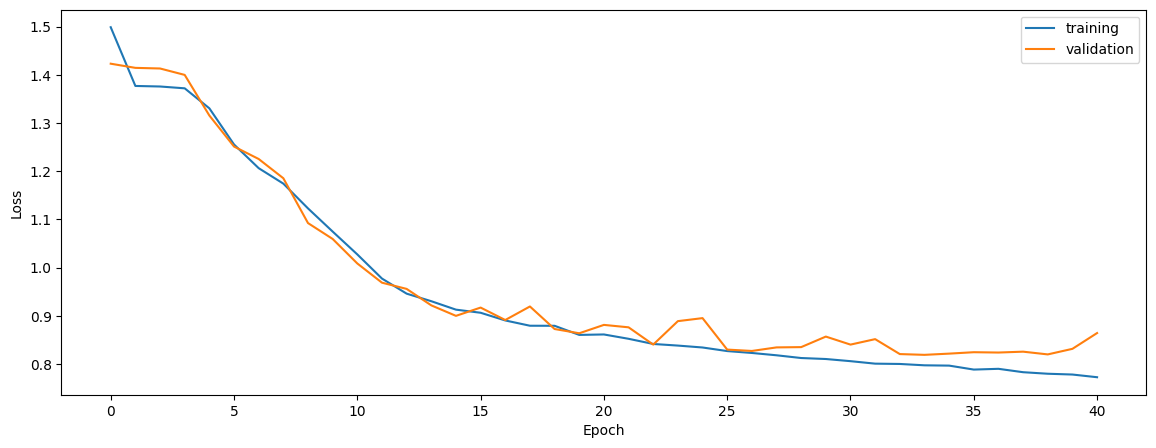

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6919085774333377
0.6822426625473951
0.6426696284329564


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6919085774333377
0.6822426625473951
0.6426696284329564


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6997014249071505
0.6985674266062359
0.6529376962635962


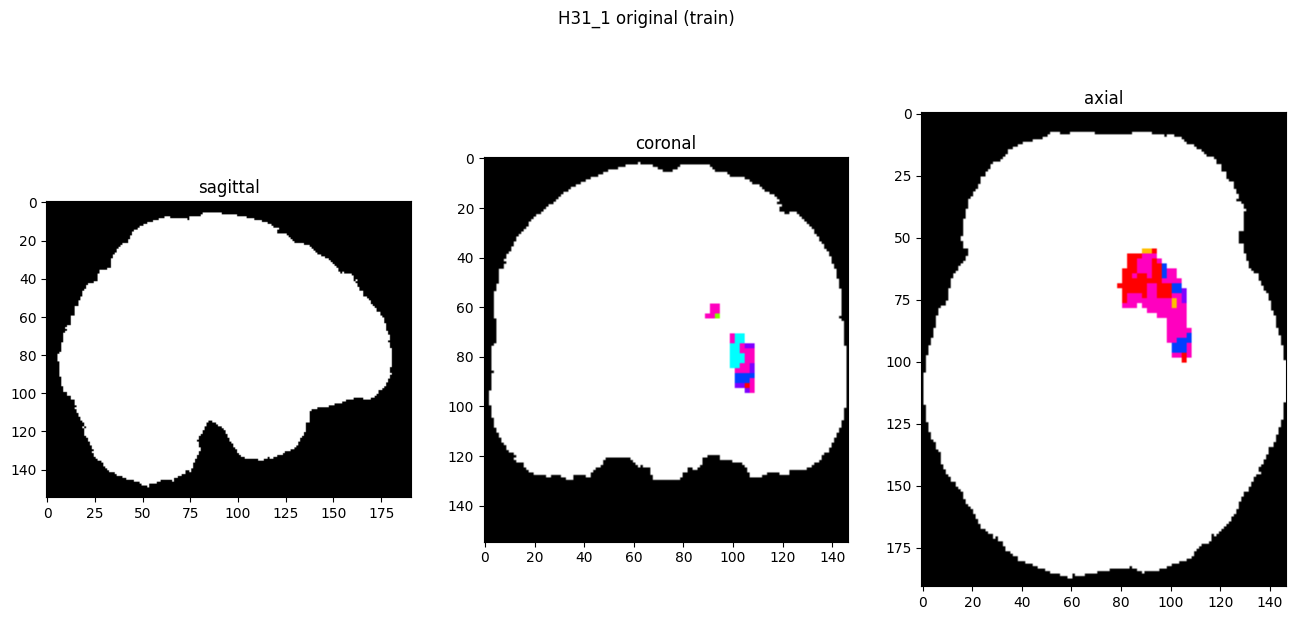

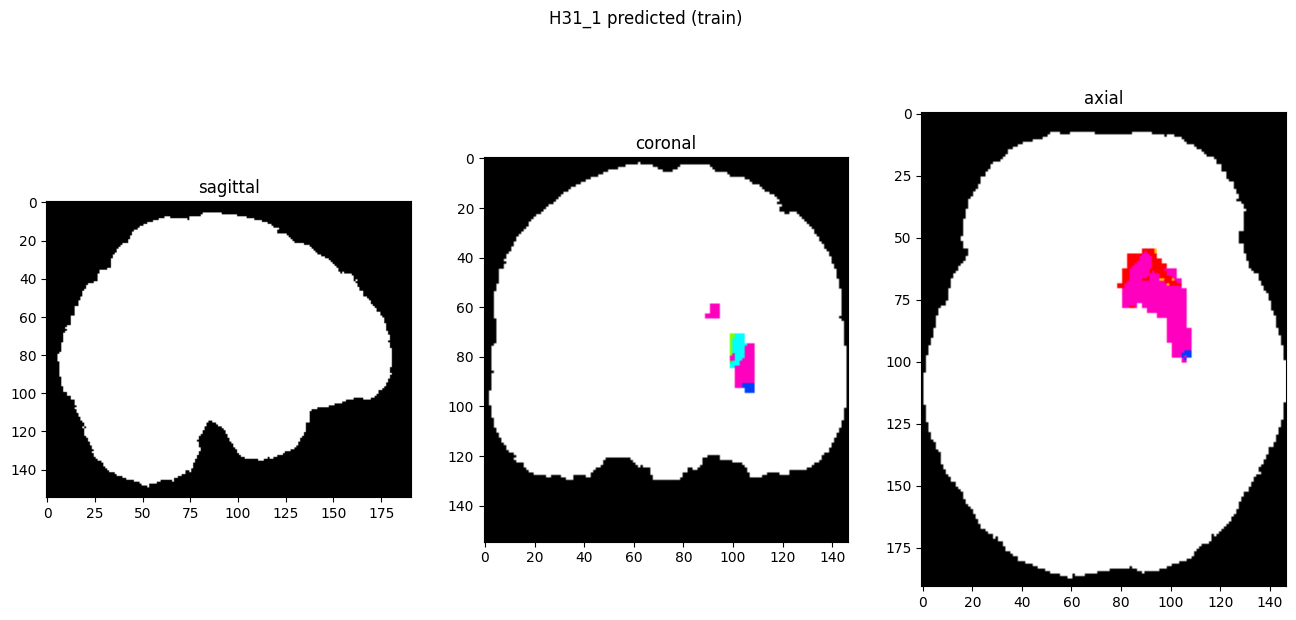

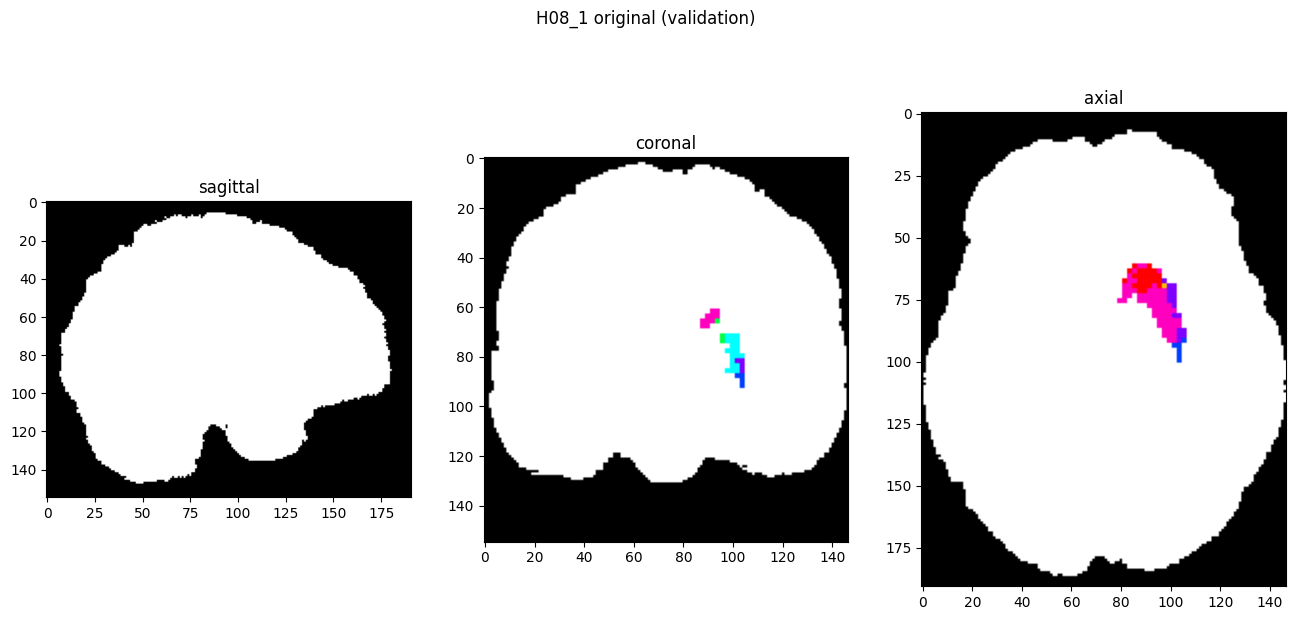

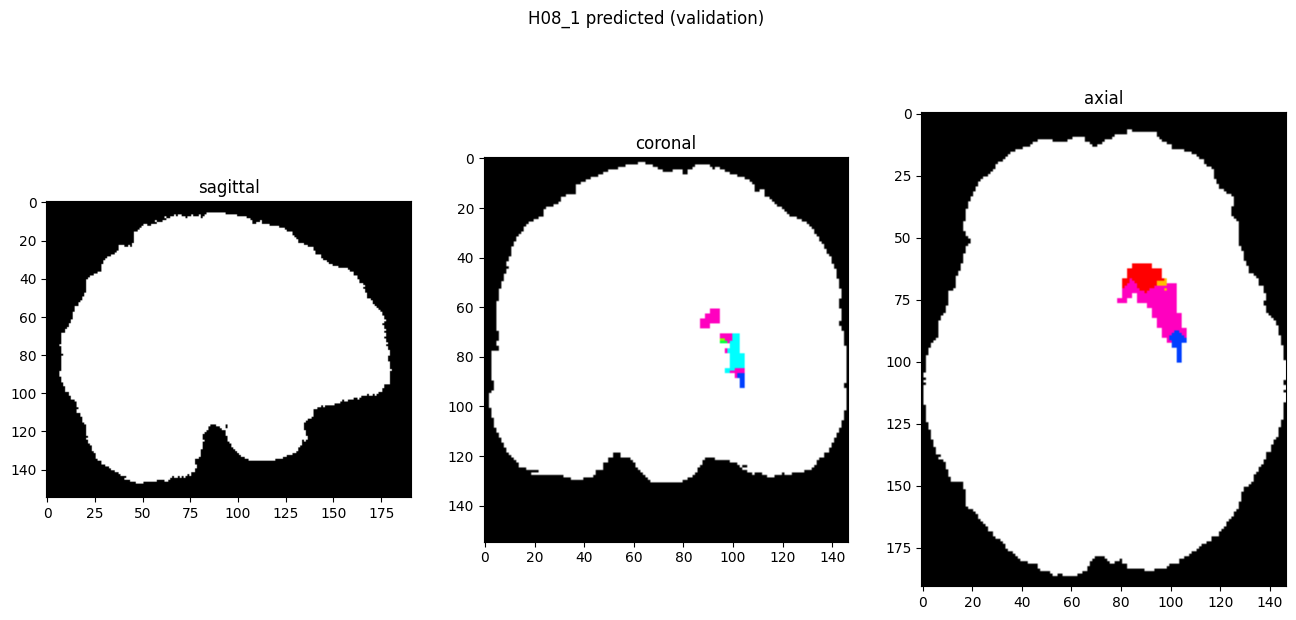

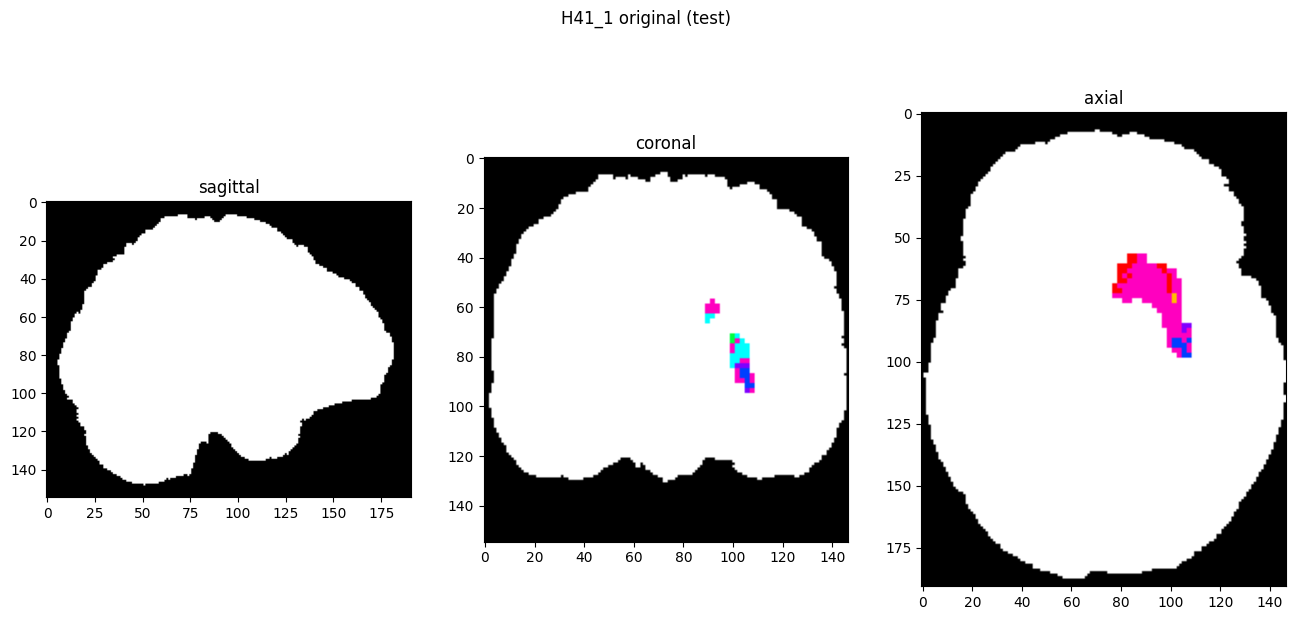

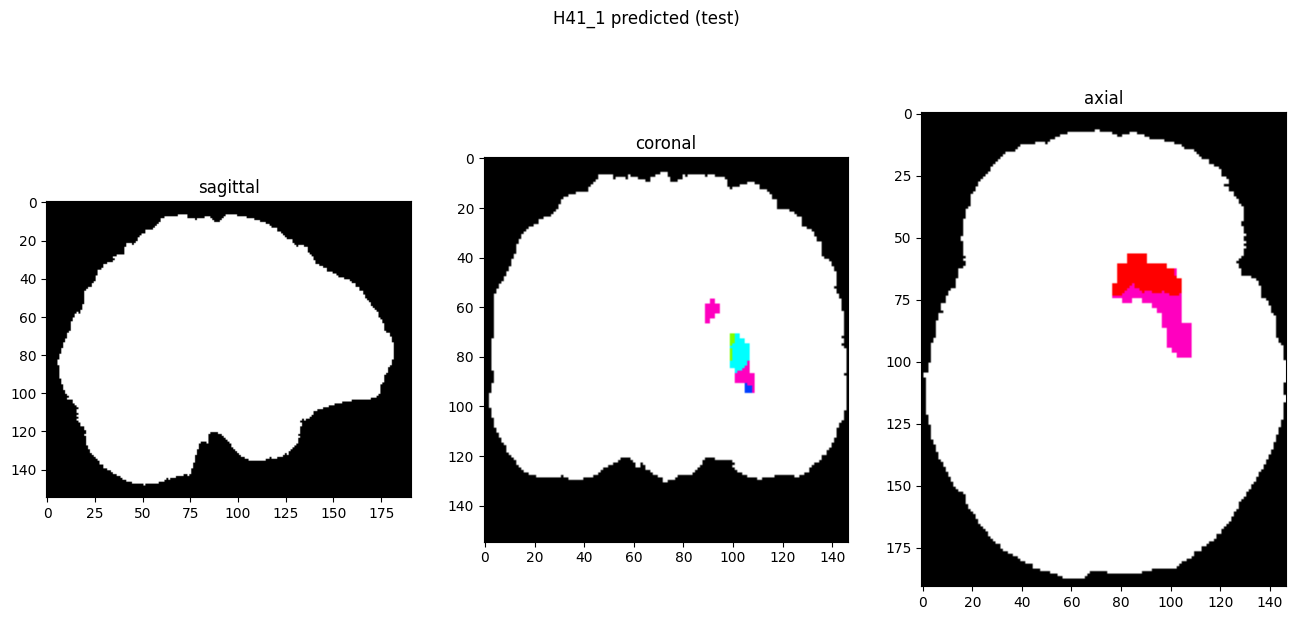

In [10]:
showResults(model, gen, threshold=0)